# Toronto COVID-19 Cases Project

Author: Adrienne Siu
Date: August 2020

# 1. Problem Definition

In this project, I will use machine learning to:
(1) Predict the outcomes of cases of COVID-19 in Toronto
(2) Find the variables that correlate most with the outcome

The dataset is available on Toronto Open Data and the version from July 29, 2020 was used: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

This dataset has been saved as 'COVID19 cases.csv'.

The three possible outcomes are: fatal, resolved (not fatal), and active.

In [1]:
# DELETE
%qtconsole
import pdb
#import contextlib
#with contextlib.redirect_stdout(None):
#import pixiedust

#%%pixie_debugger
#pdb.set_trace()

# 2. Exploratory Data Analysis (EDA)

In this section, I will explore the data, including correlations between variables and outcomes.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt

In [3]:
# Path of dataset file (.csv)
covid_file_path = 'COVID19 cases.csv'

# Read the file
covid_data = pd.read_csv(covid_file_path)

In [4]:
# Display the first few rows of the dataset
covid_data.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [5]:
# Function to obtain filtered entries in dataset
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry is a string for the entry to be filtered
# Ex. To filter only the fatal outcomes, filter_column = 'Outcome' and filter_entry = 'FATAL'
# Returns entries and value counts for the specific column after filtering
def get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry):
    # Get the count of each unique entry (ordered by name)
    entry_vc = covid_data[covid_data[filter_column]==filter_entry][column_name].value_counts() #.sort_index()
    # Get the unique entries and put them in a list
    entry = entry_vc.index.tolist()    
    return entry, entry_vc

In [6]:
# Function to create a bar chart of a column variable with filters applied
# Stack by outcome: active, fatal, resolved
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry_list is a list of strings for entries to be filtered
def create_filtered_bar_chart(column_name, filter_column, filter_entry_list, fig_size):
    # Initialize lists of entries and value counts after filtering
    entry_list = []
    entry_vc_list = []
    
    # Figure size
    if fig_size == 'large':
        fig = plt.figure(figsize=(20,30))
        #plt.xticks(rotation=90)
    else:
        fig = plt.figure()

    # Loop through entries to be filtered
    for i in range(len(filter_entry_list)):
        # Entries and value counts for each filter
        entry, entry_vc = get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry_list[i])
        # Append to list
        entry_list.append(entry)
        entry_vc_list.append(entry_vc)
        # Create a bar stacked for each filtered entry, e.g. 'Fatal', 'Active', 'Resolved'
        #plt.bar(entry_list[i], entry_vc_list[i])
        plt.barh(entry_list[i], entry_vc_list[i])

    # Invert the y-axis so that the order of the entries is from top to bottom
    plt.gca().invert_yaxis()
    plt.title('Number of COVID-19 Cases By ' + column_name)
    plt.legend(filter_entry_list)
    plt.show()

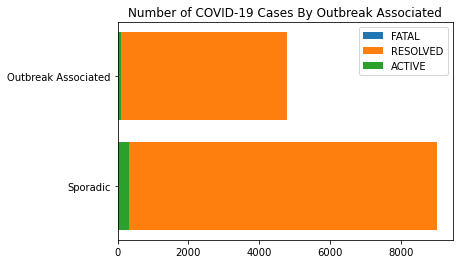

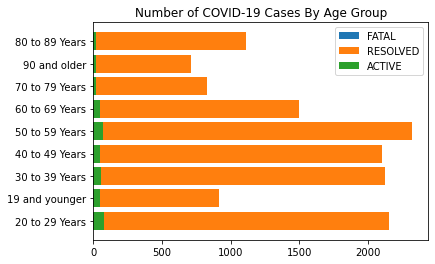

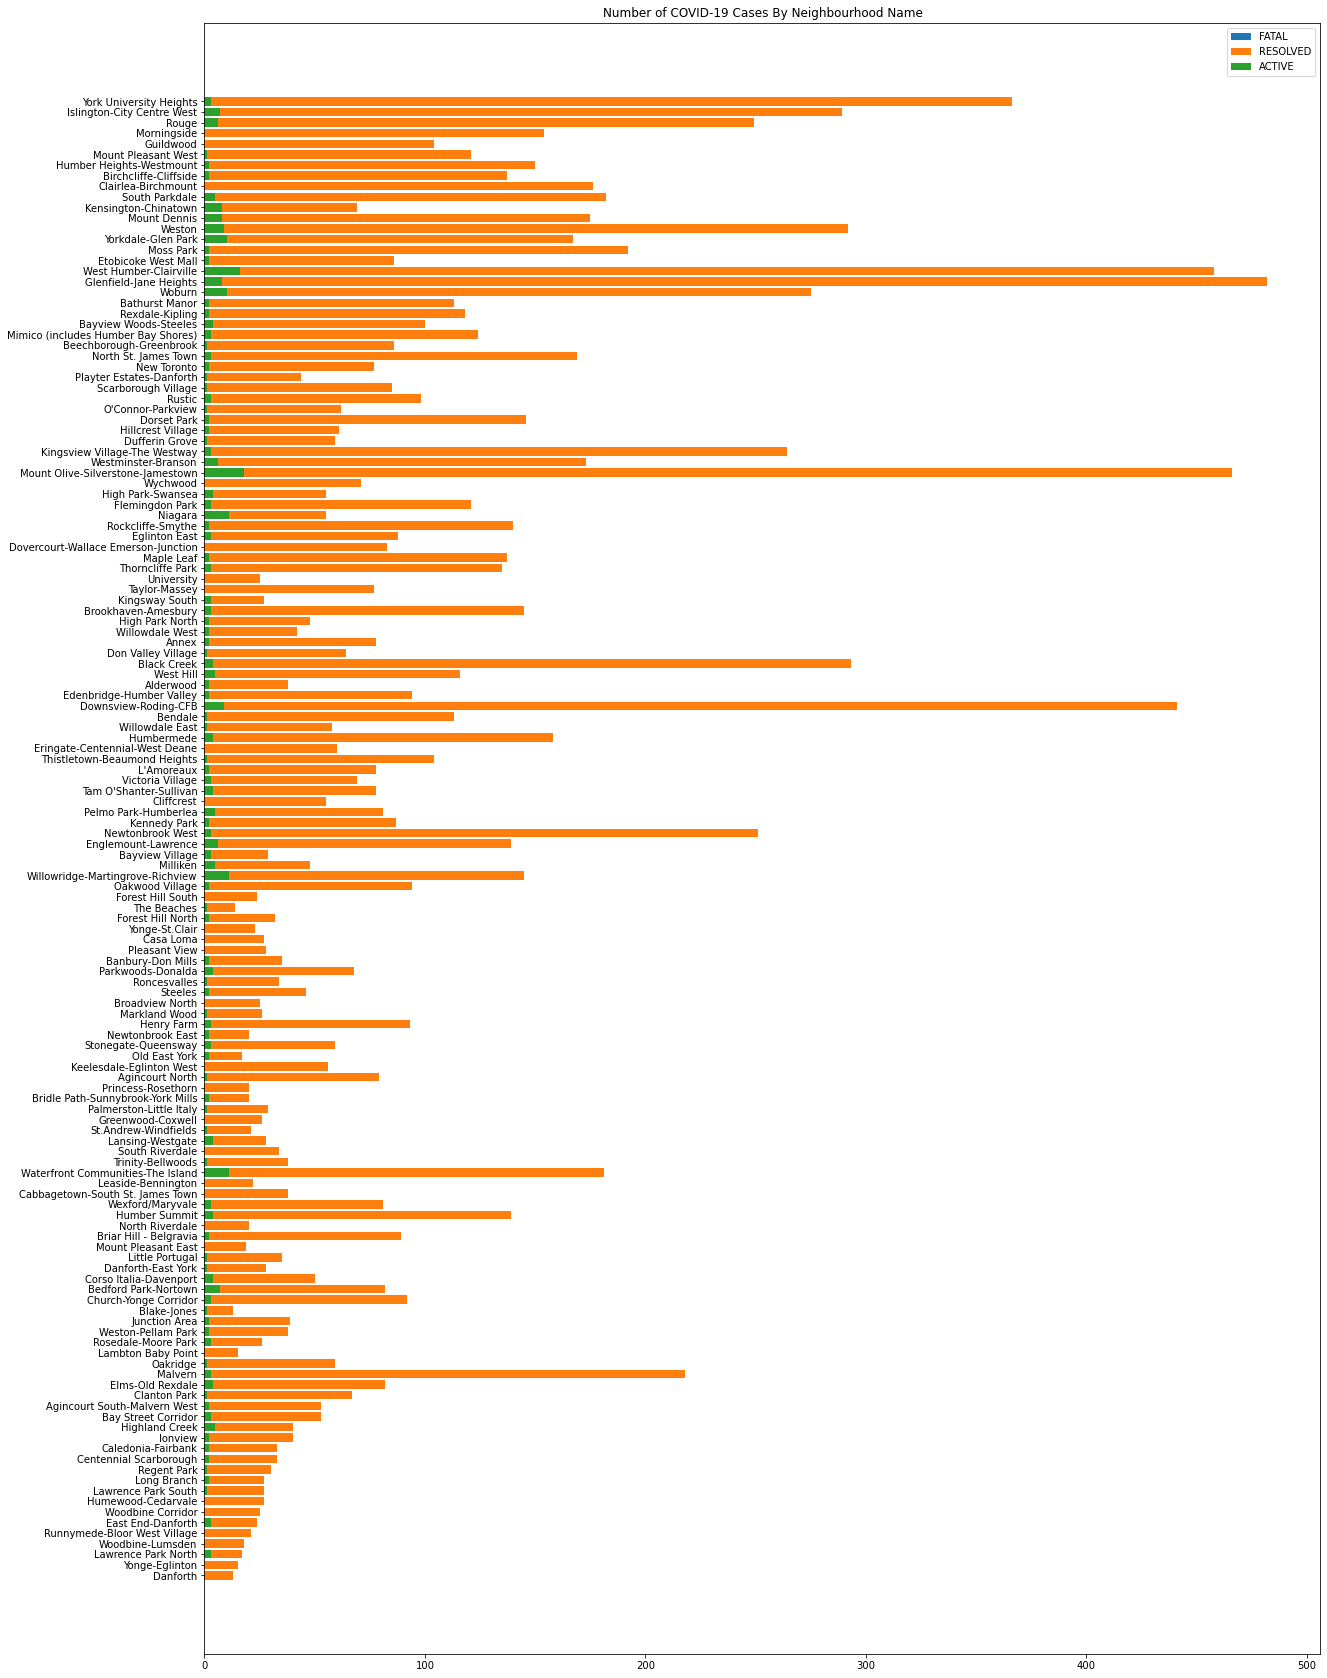

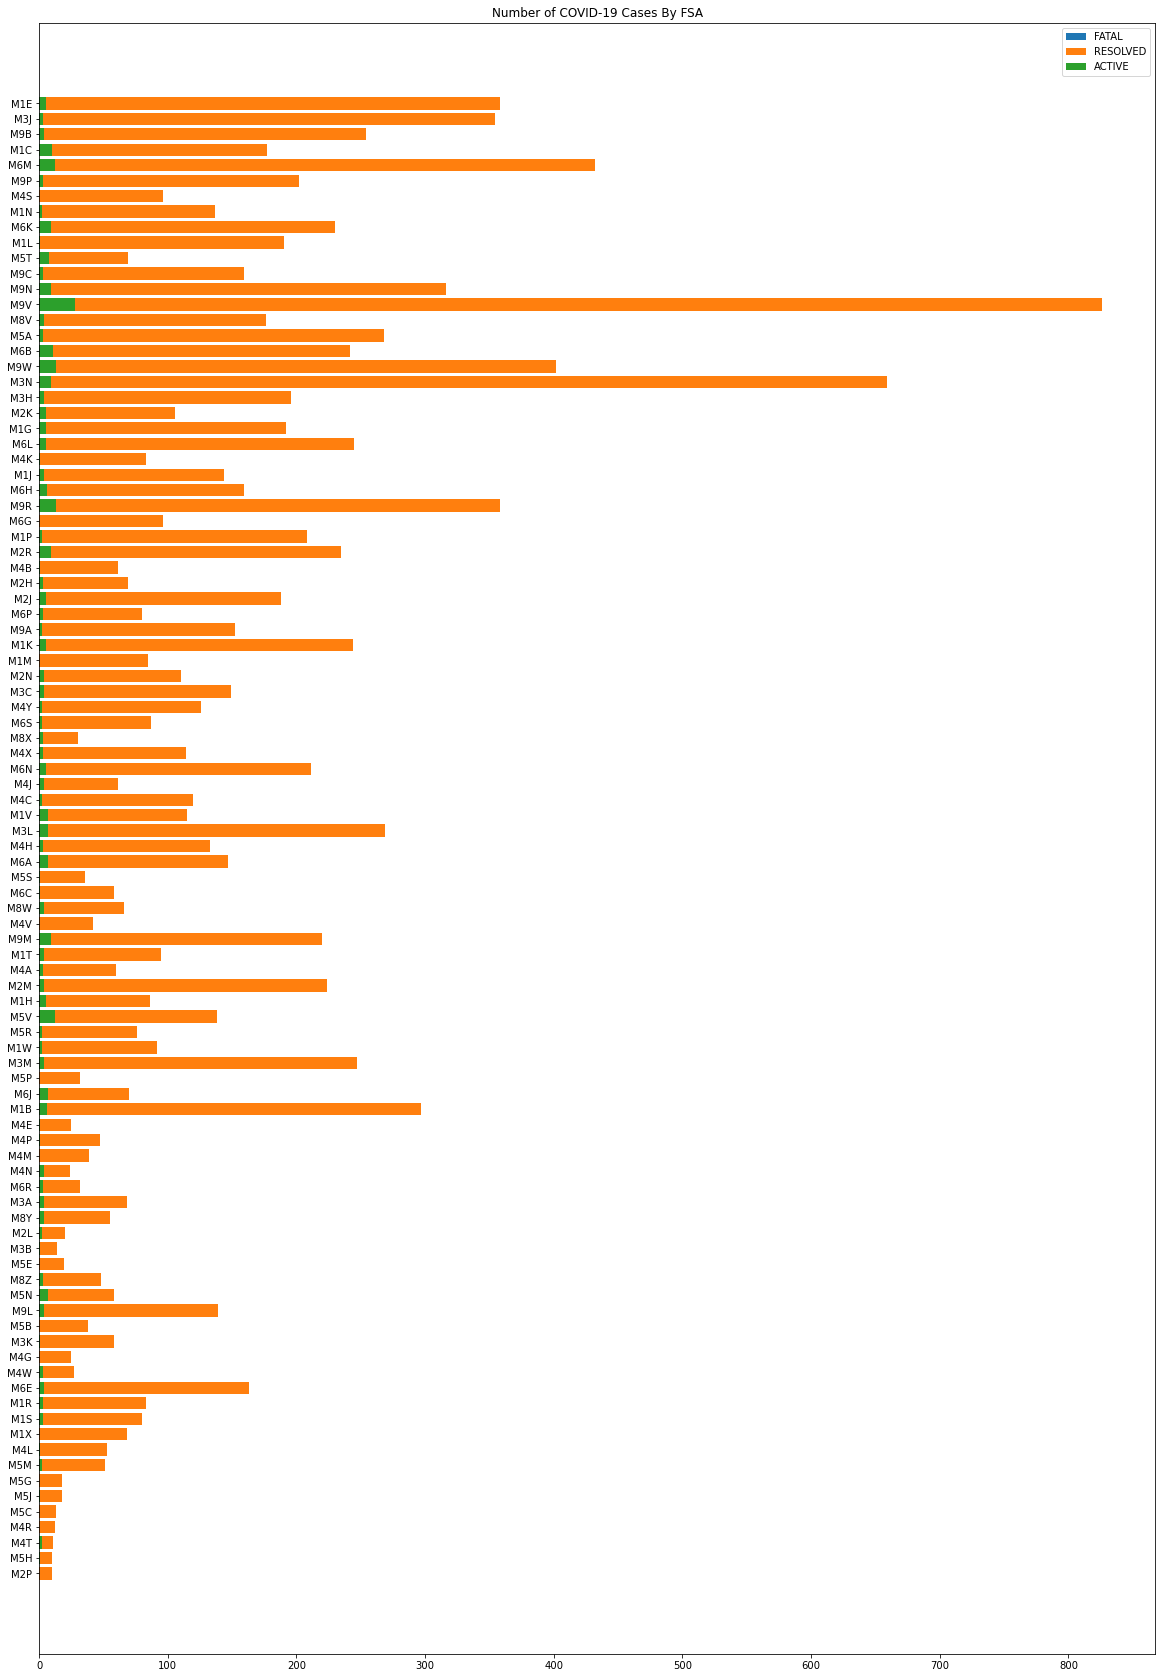

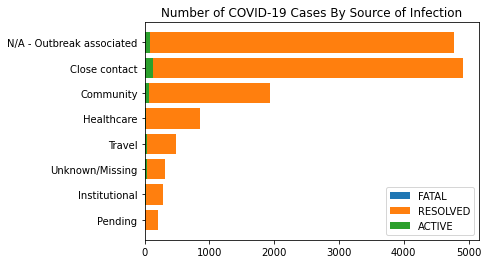

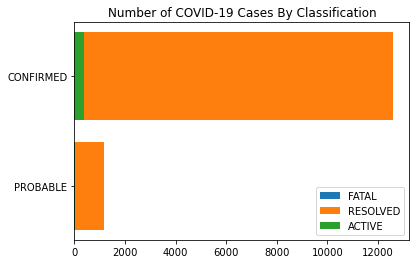

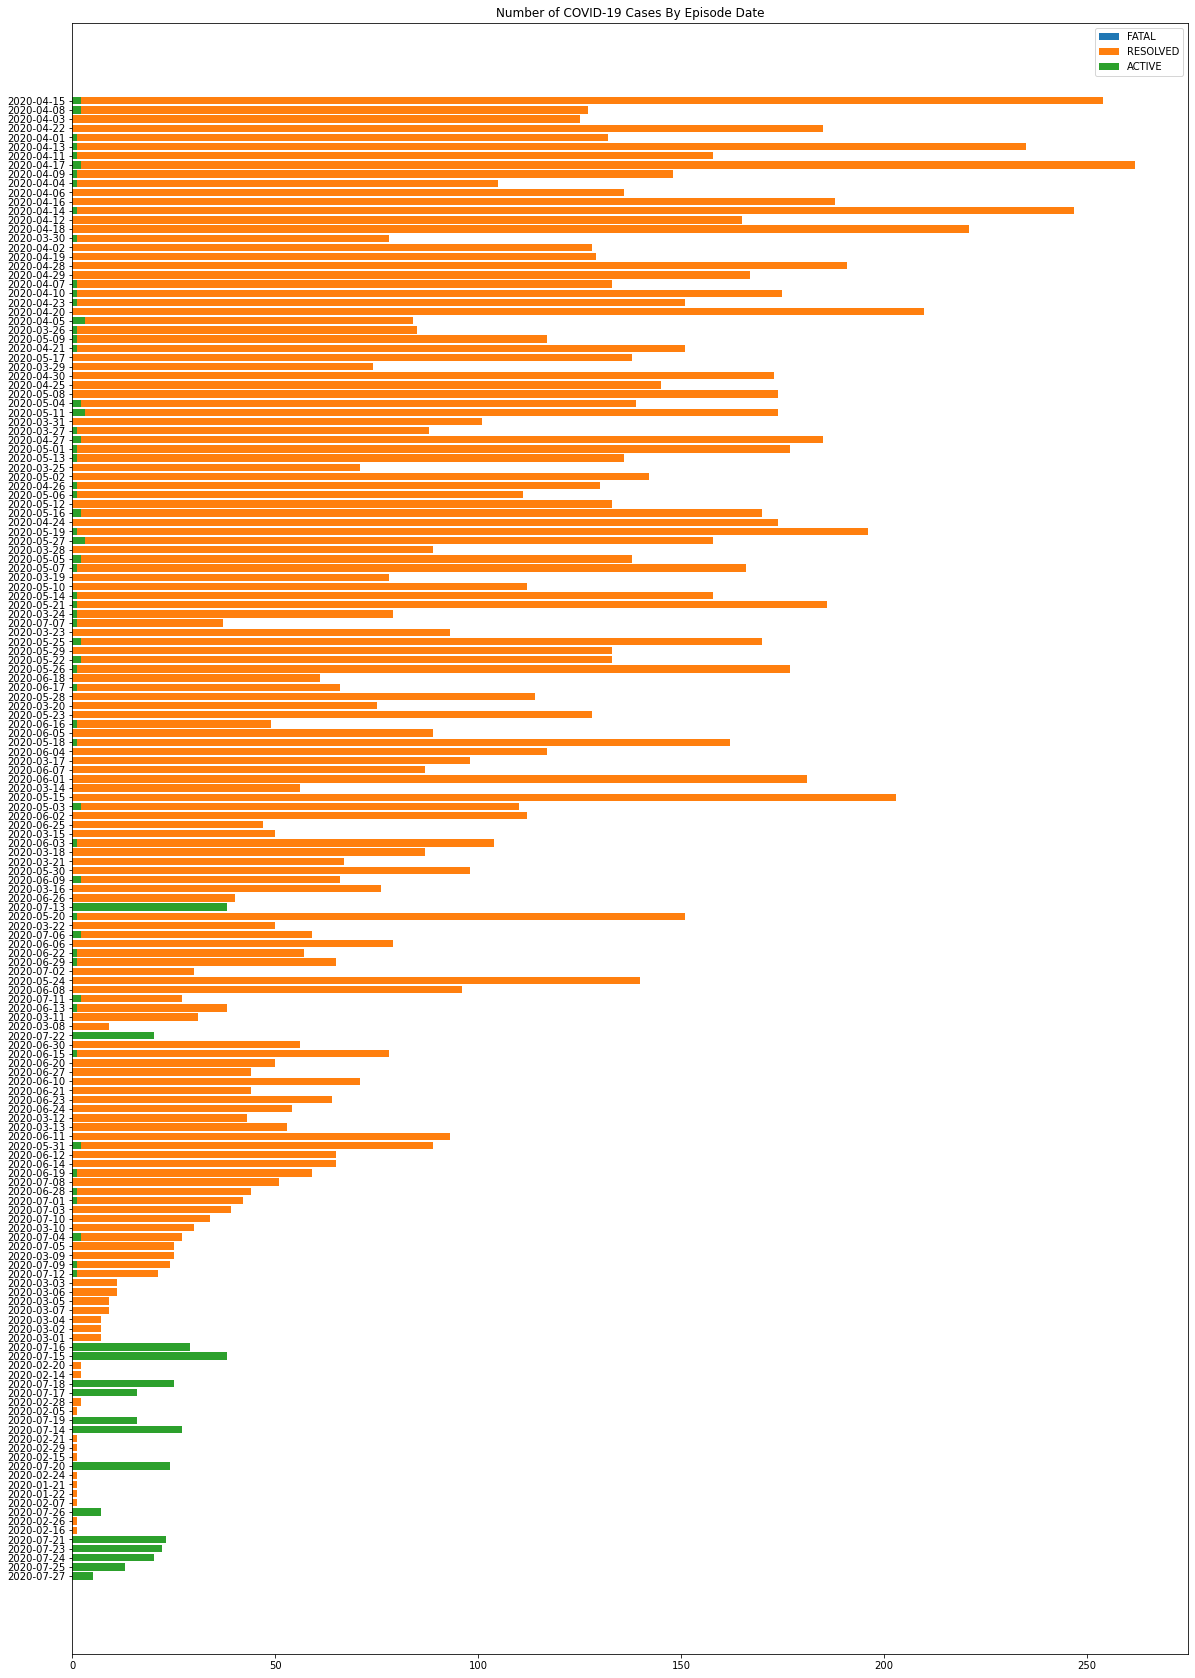

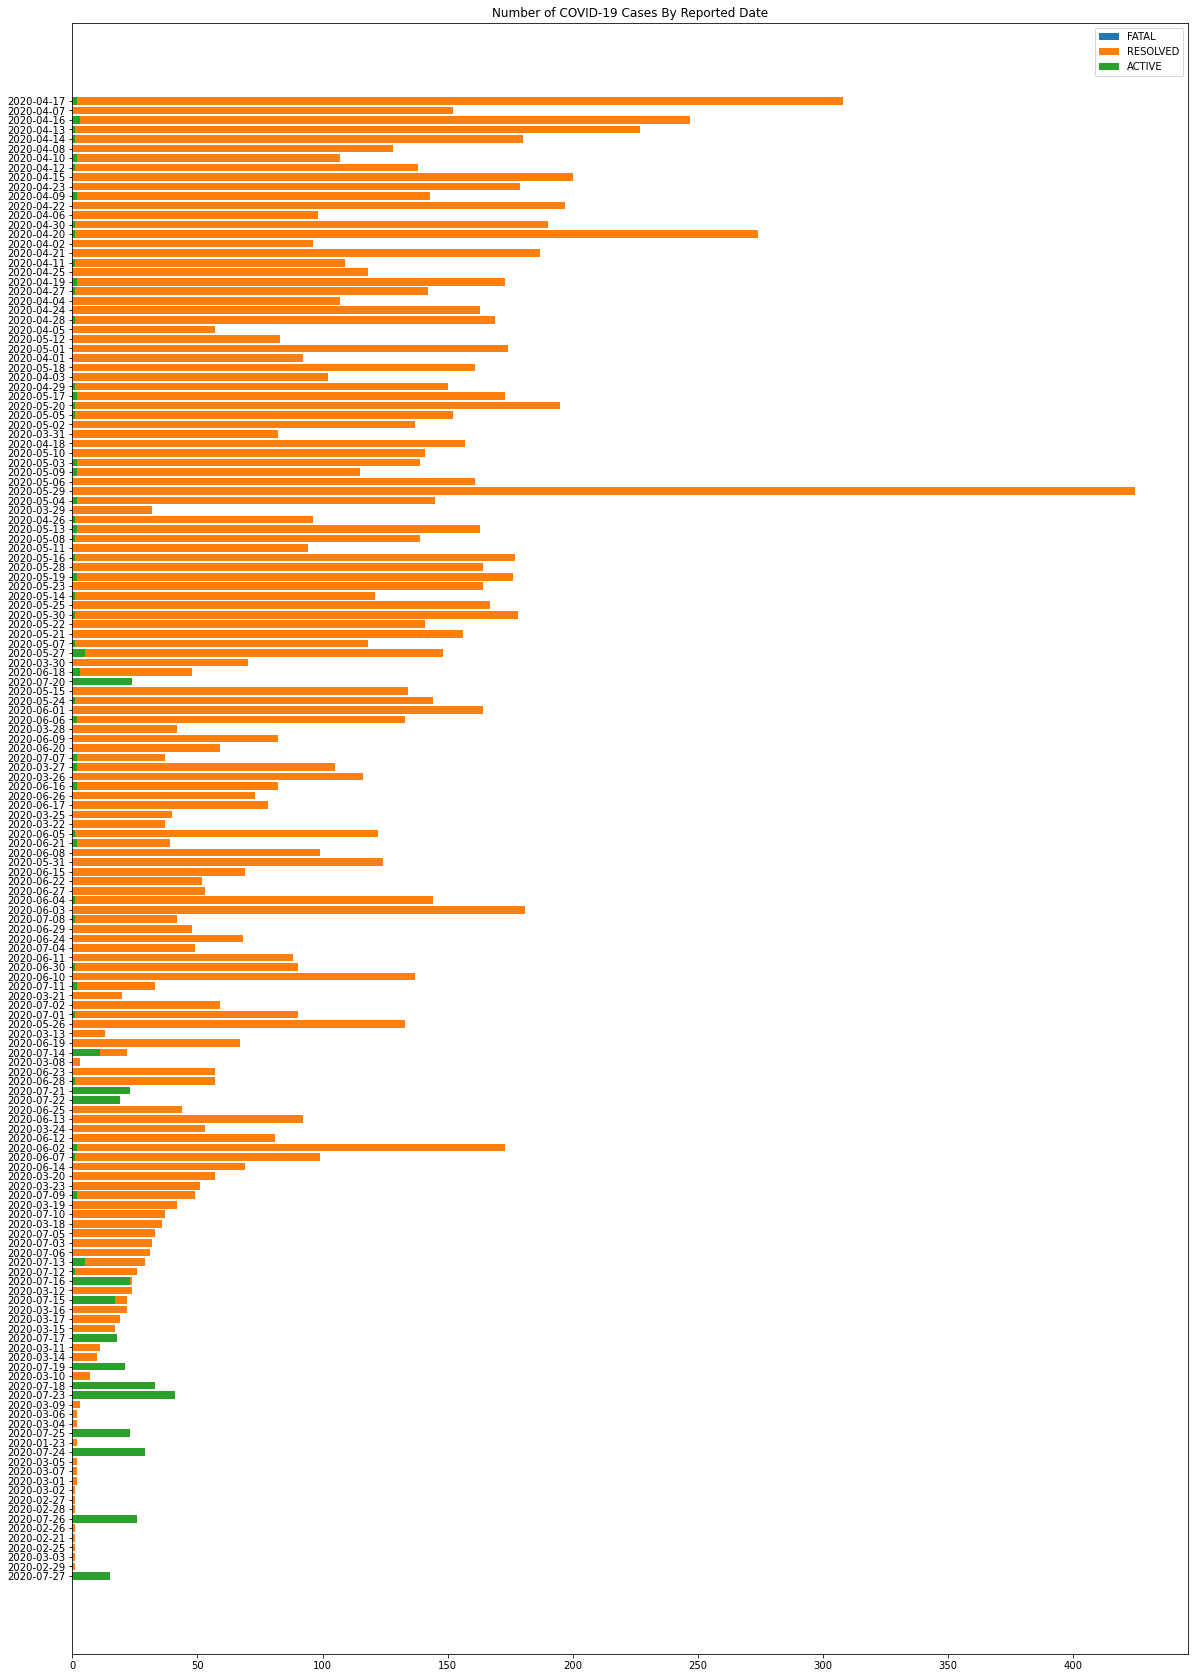

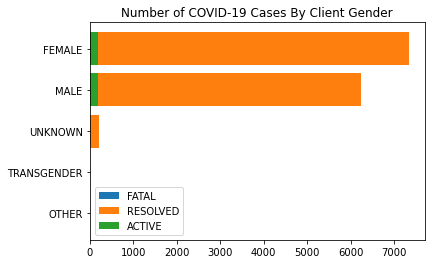

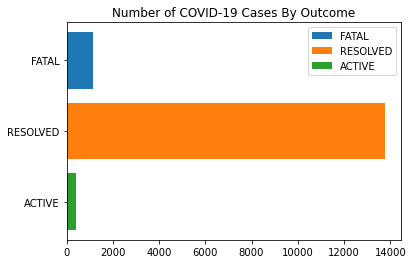

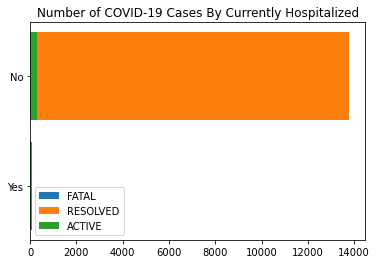

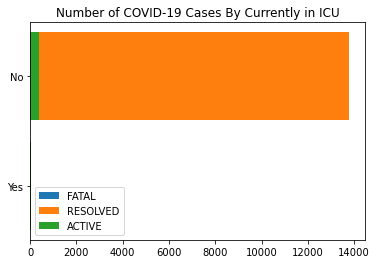

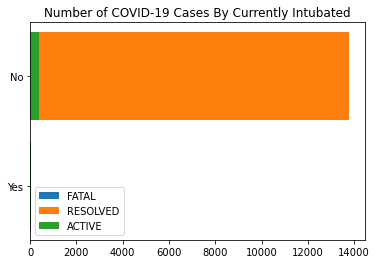

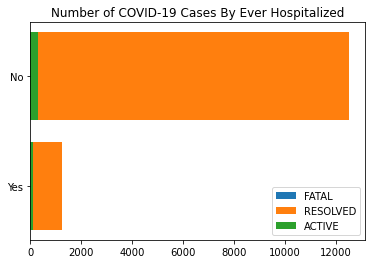

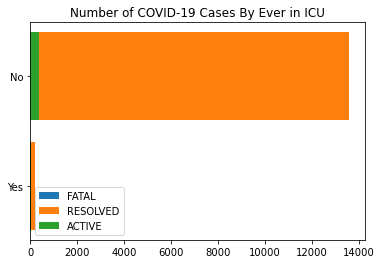

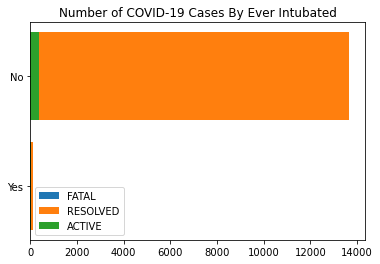

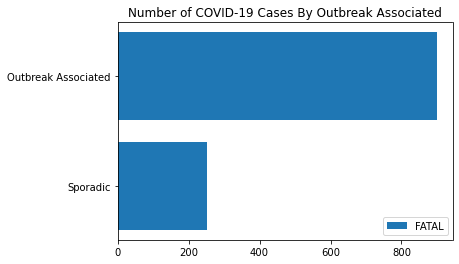

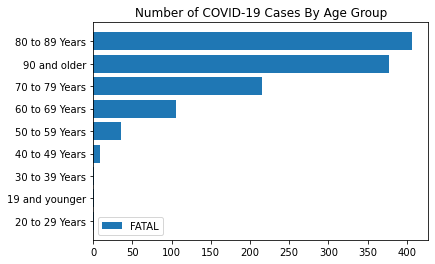

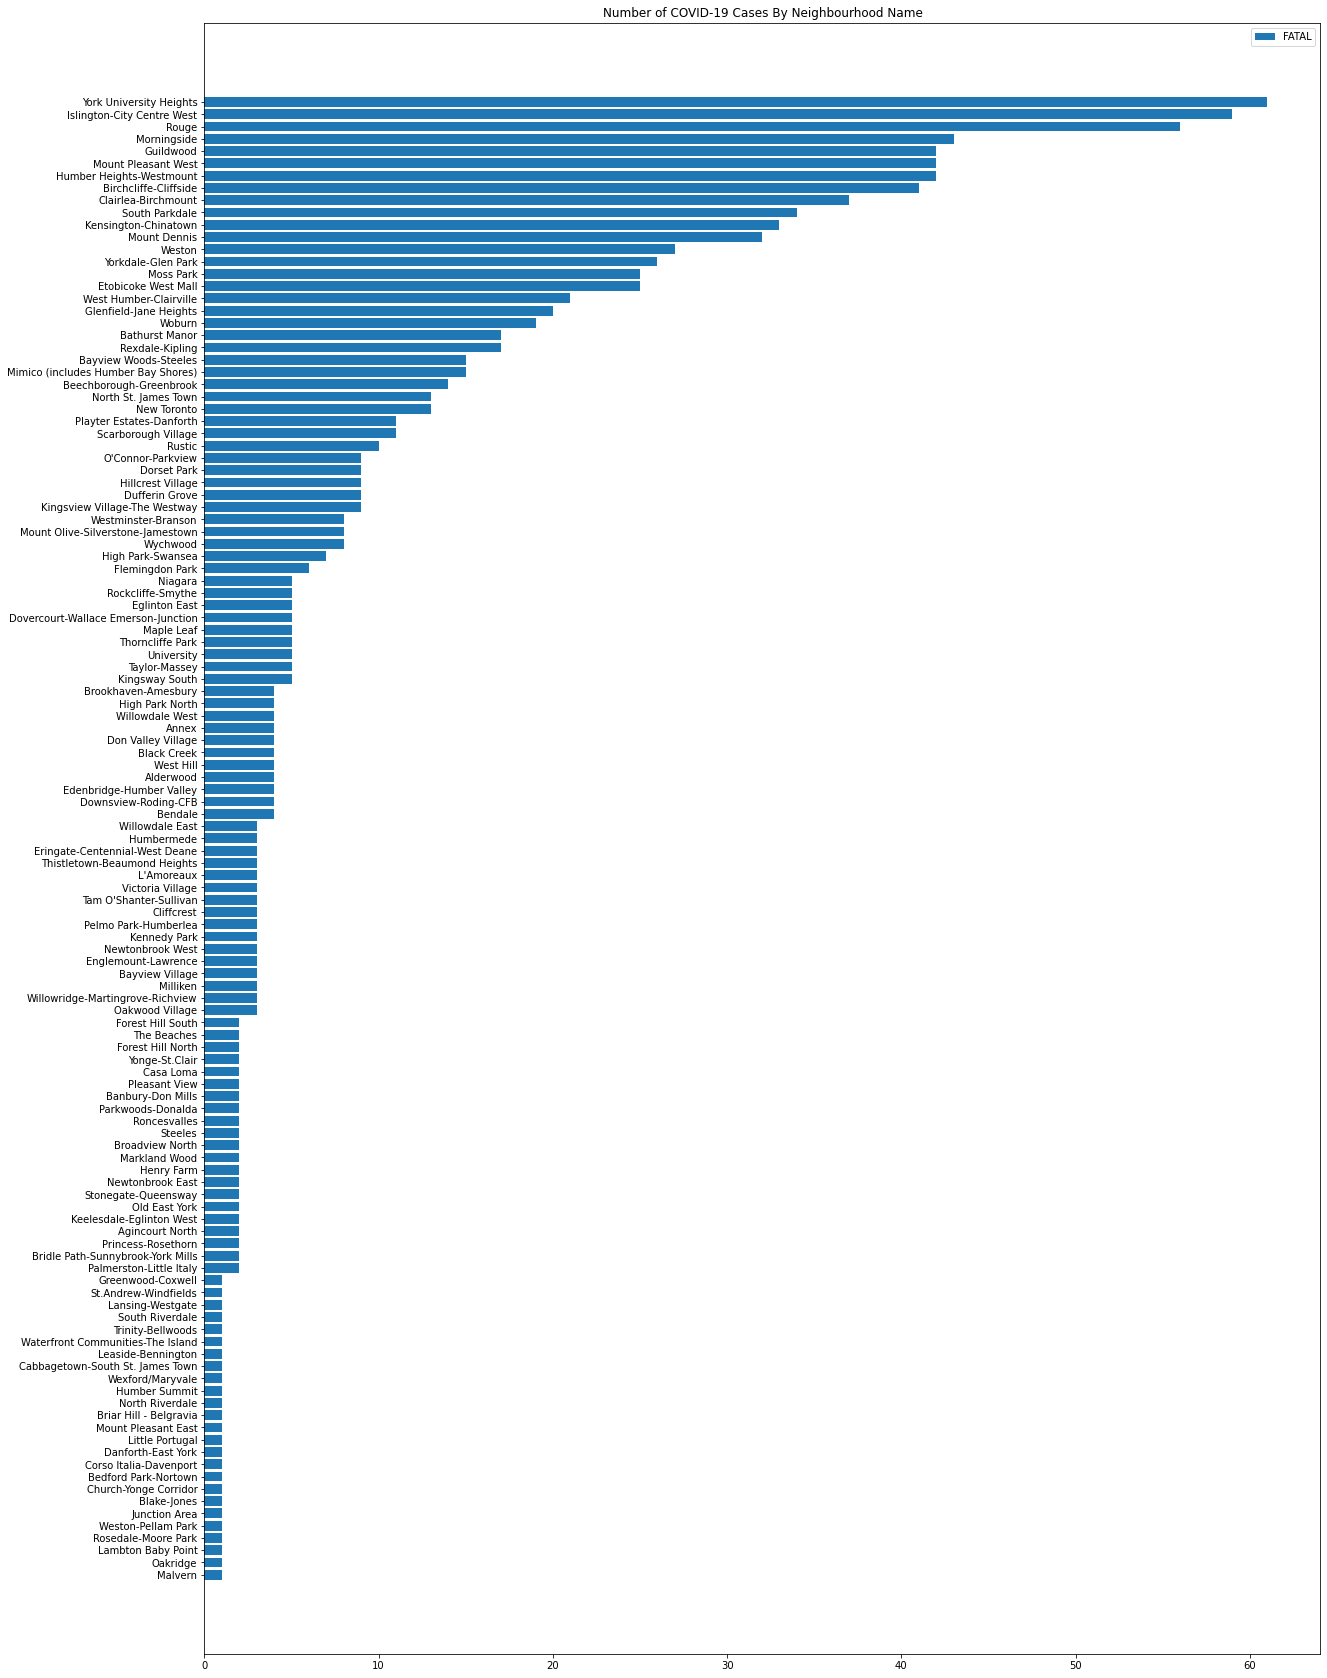

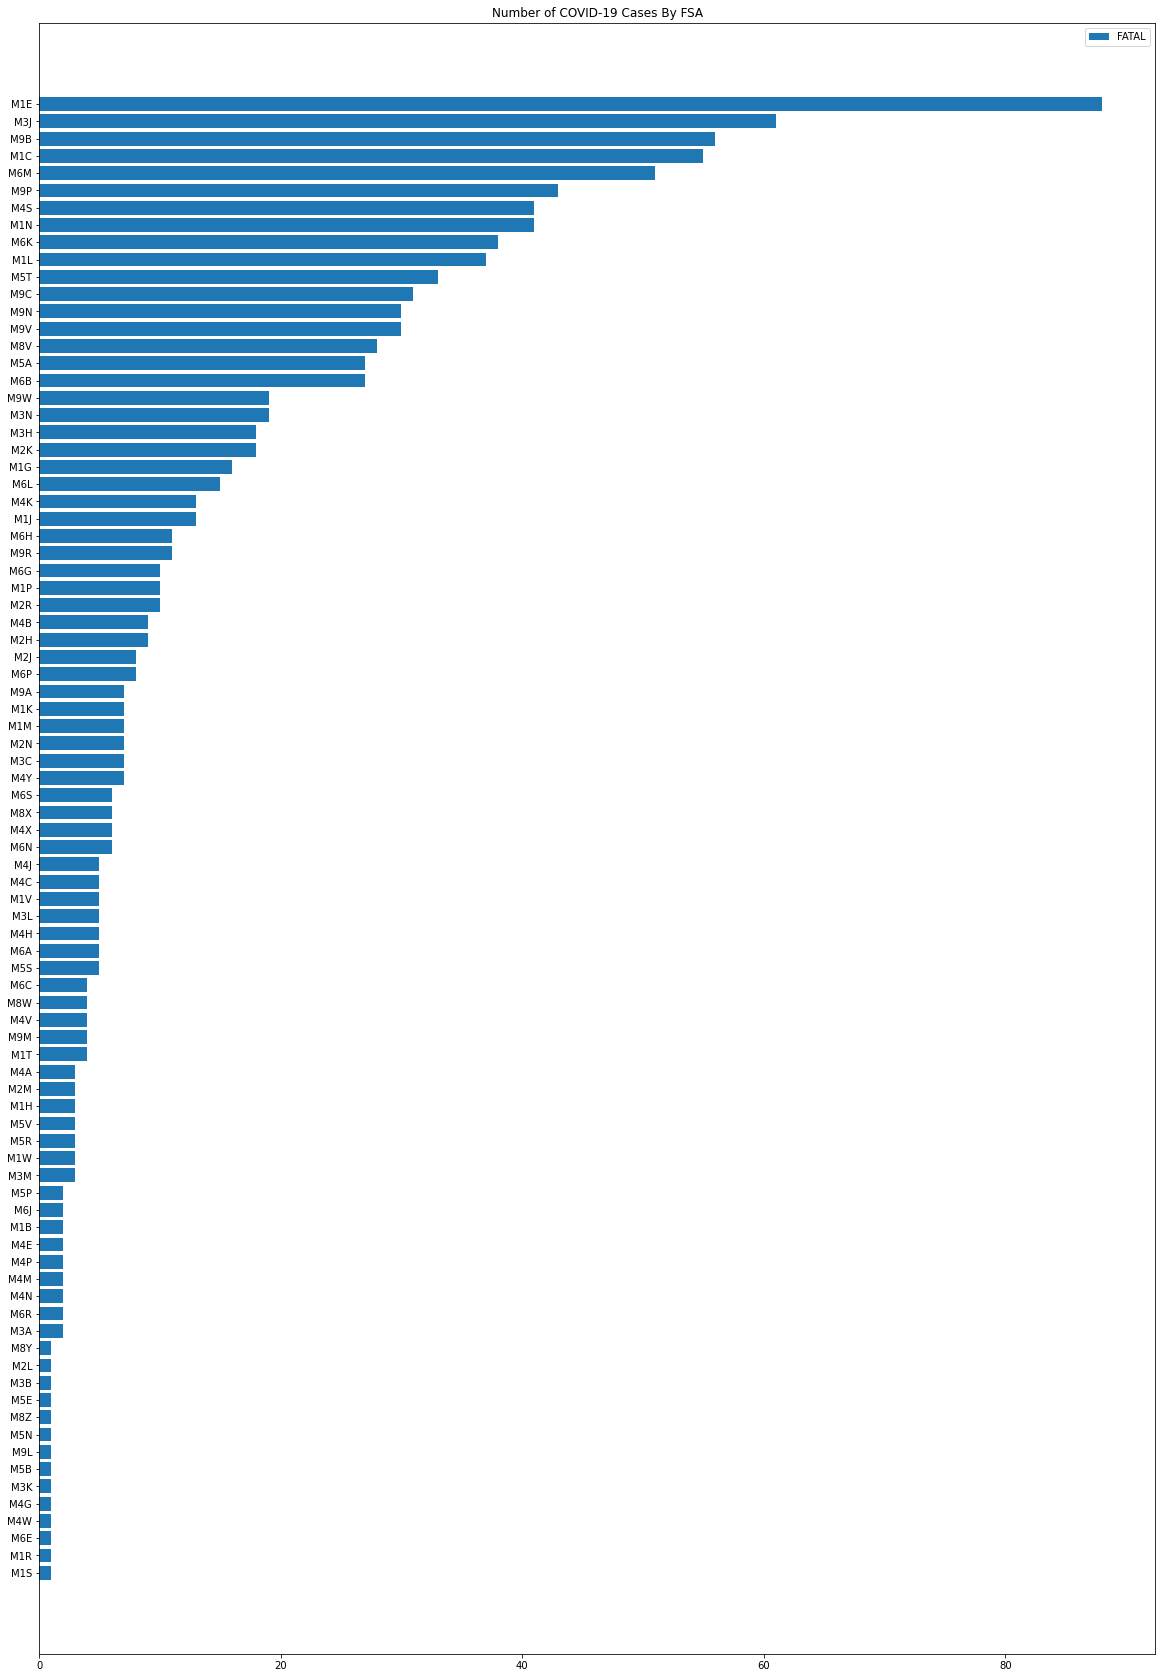

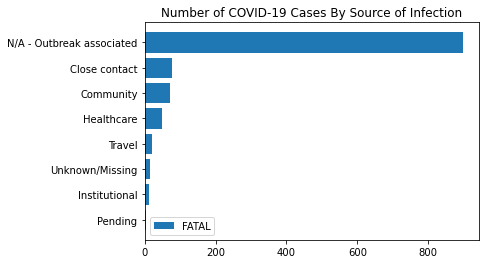

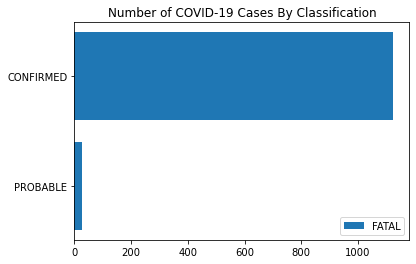

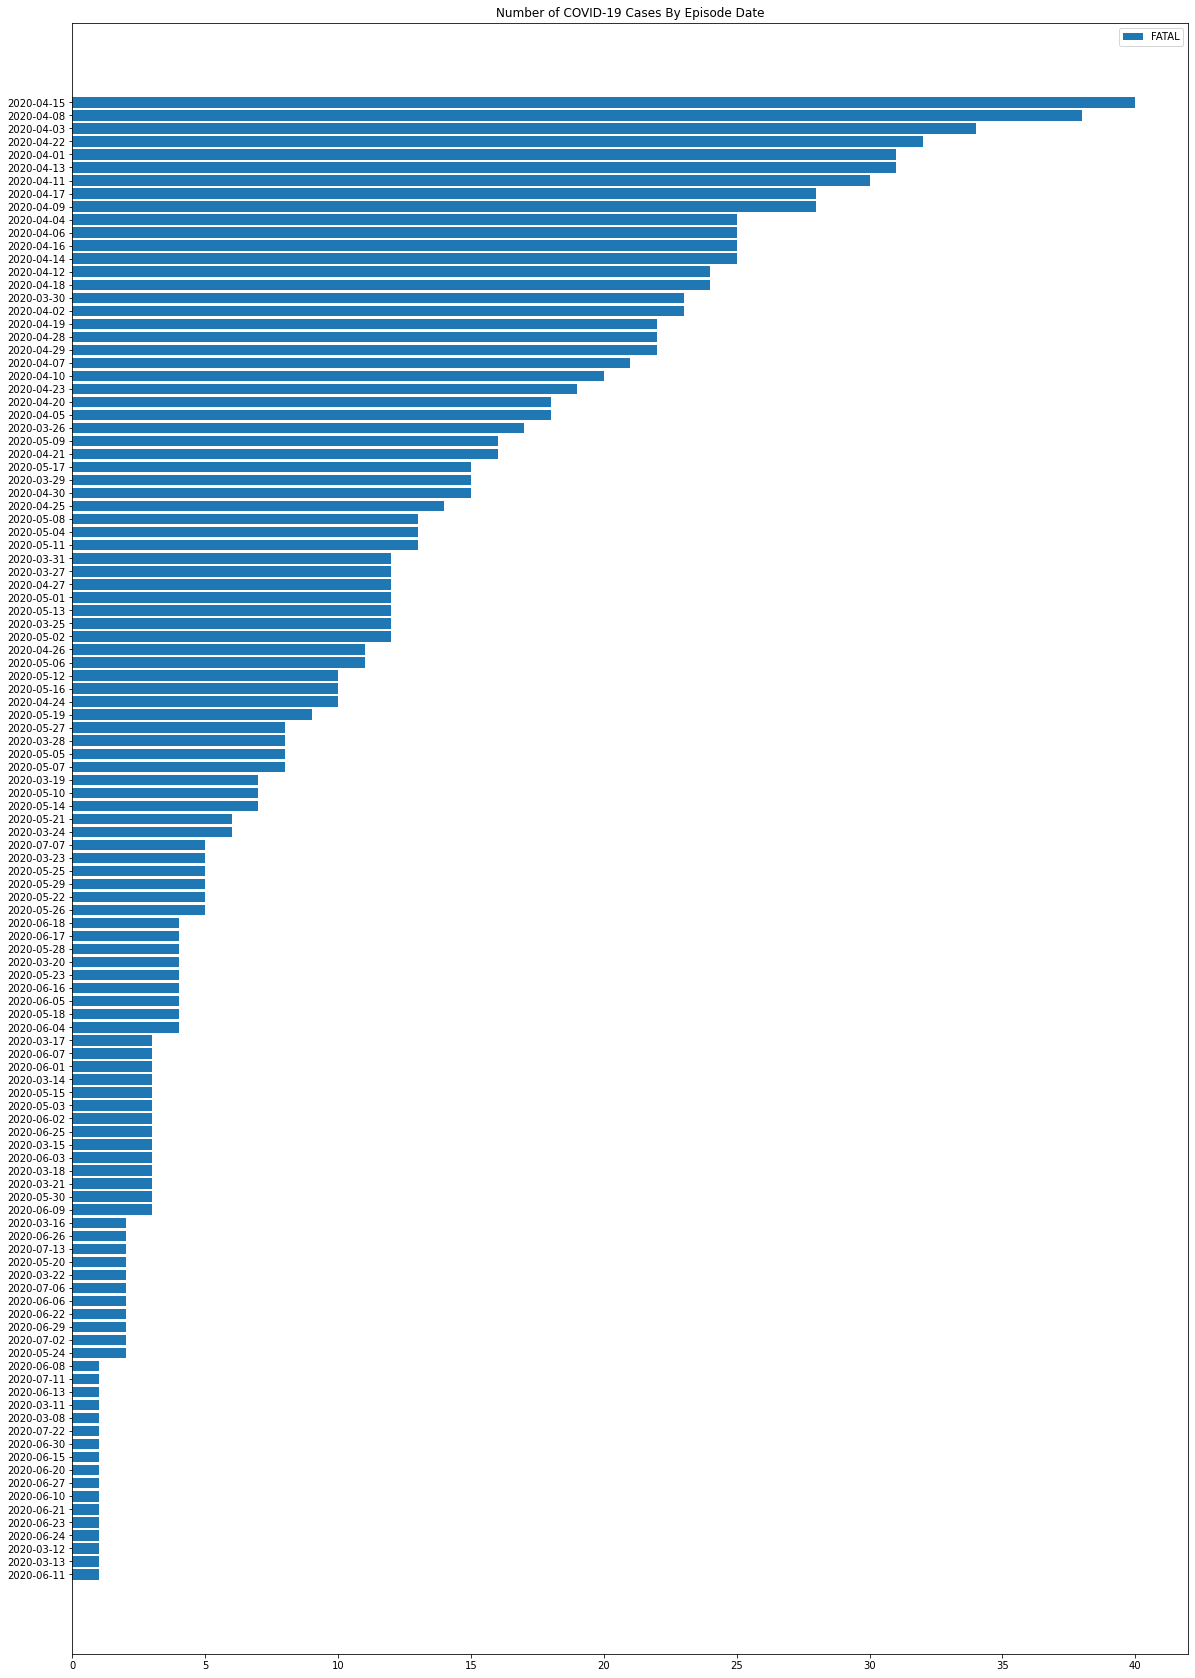

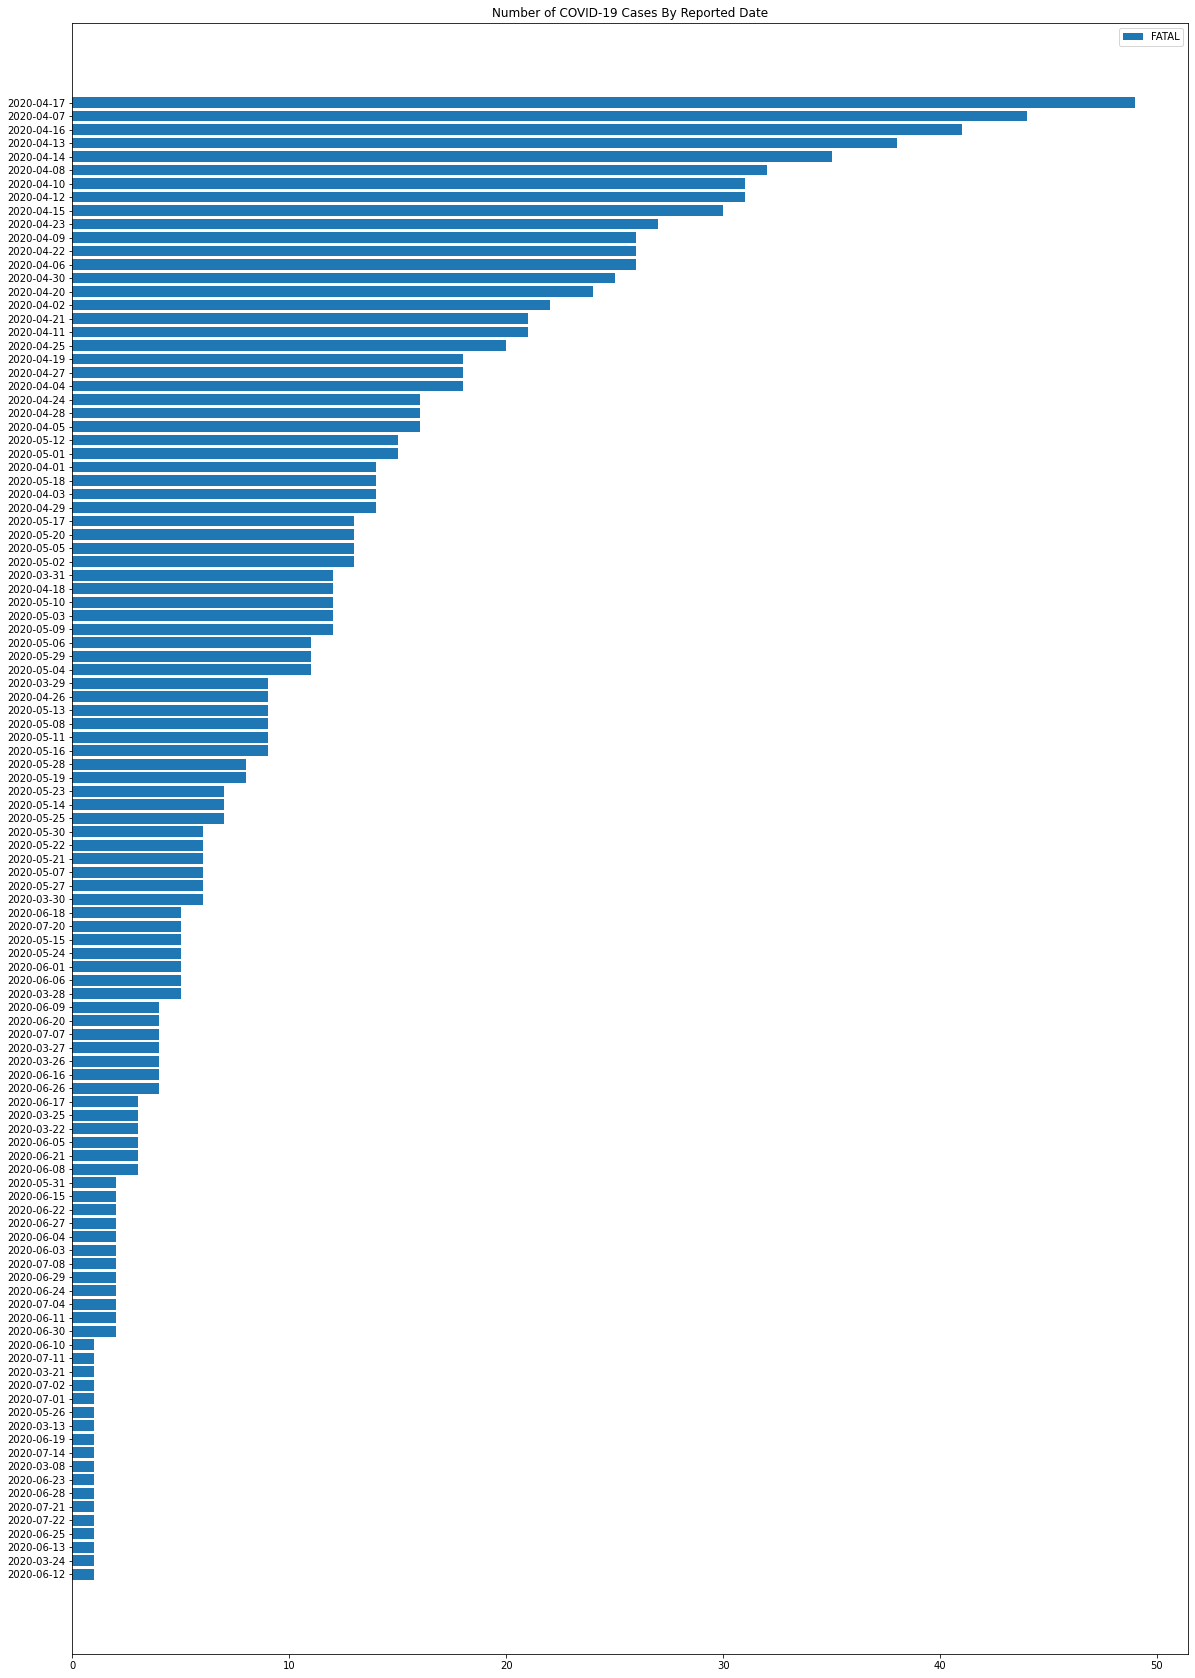

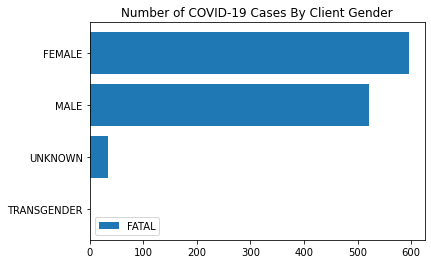

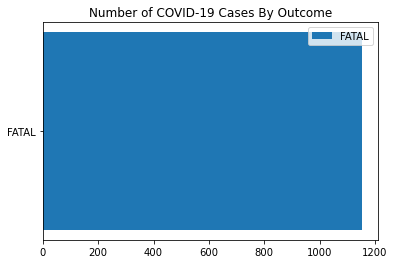

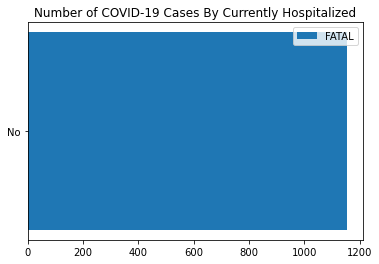

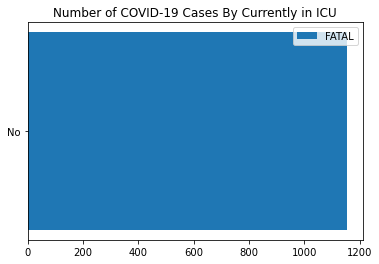

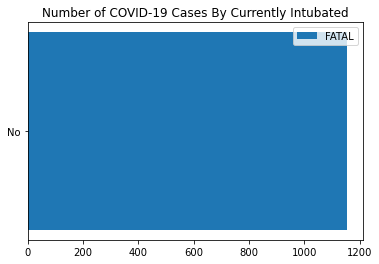

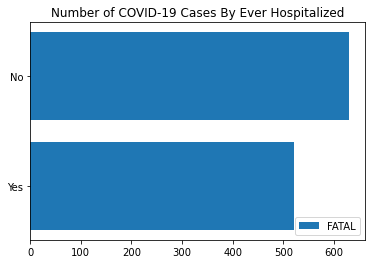

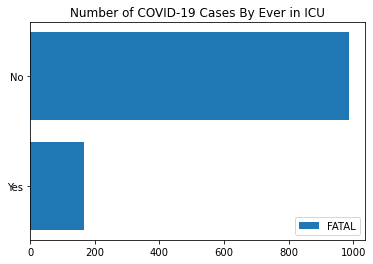

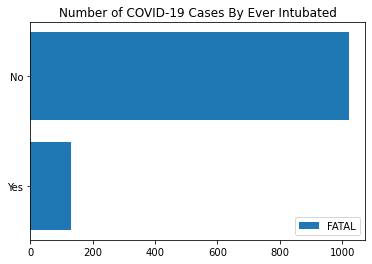

In [7]:
# Put the column names of the dataset into a list
columns = covid_data.columns

# Remove the first two column names (the IDs) because I don't need to graph them
columns_no_IDs = columns[2:]

# Column to be filtered
filter_column = 'Outcome'
# Entries to be filtered:
# First make stacked bar charts of all three outcomes, then bar charts of only fatal outcomes
filter_entry_list = [['FATAL', 'RESOLVED', 'ACTIVE'], ['FATAL']]

for j in range(len(filter_entry_list)):
    # Create bar charts for relevant columns
    for column in columns_no_IDs:
        #create_bar_chart(column)
        # Figure size
        if column == 'Neighbourhood Name' or column == 'FSA' or column == 'Episode Date' or column == 'Reported Date':
            fig_size = 'large'
        else:
            fig_size = 'normal'

        create_filtered_bar_chart(column, filter_column, filter_entry_list[j], fig_size)

In [8]:
from datetime import datetime as dt

date_obj = ['str']*len(covid_data['Episode Date'])
for i in range(len(covid_data['Episode Date'])):
    print(i)
    date_obj[i] = dt.strptime(covid_data['Episode Date'][i], '%Y-%m-%d')
    


0
2020-01-22 00:00:00
1
2020-01-21 00:00:00
2
2020-02-05 00:00:00
3
2020-02-16 00:00:00
4
2020-02-20 00:00:00
5
2020-02-24 00:00:00
6
2020-02-20 00:00:00
7
2020-02-21 00:00:00
8
2020-02-29 00:00:00
9
2020-02-26 00:00:00
10
2020-02-14 00:00:00
11
2020-03-01 00:00:00
12
2020-03-02 00:00:00
13
2020-03-03 00:00:00
14
2020-03-02 00:00:00
15
2020-03-03 00:00:00
16
2020-03-02 00:00:00
17
2020-03-04 00:00:00
18
2020-03-06 00:00:00
19
2020-03-05 00:00:00
20
2020-03-03 00:00:00
21
2020-03-03 00:00:00
22
2020-03-04 00:00:00
23
2020-03-09 00:00:00
24
2020-03-02 00:00:00
25
2020-03-03 00:00:00
26
2020-03-09 00:00:00
27
2020-03-02 00:00:00
28
2020-03-07 00:00:00
29
2020-03-09 00:00:00
30
2020-02-28 00:00:00
31
2020-03-09 00:00:00
32
2020-03-07 00:00:00
33
2020-03-09 00:00:00
34
2020-03-10 00:00:00
35
2020-03-07 00:00:00
36
2020-03-04 00:00:00
37
2020-03-09 00:00:00
38
2020-03-08 00:00:00
39
2020-03-09 00:00:00
40
2020-03-09 00:00:00
41
2020-03-11 00:00:00
42
2020-03-03 00:00:00
43
2020-03-10 00:00:0

2020-03-24 00:00:00
724
2020-03-18 00:00:00
725
2020-03-23 00:00:00
726
2020-03-23 00:00:00
727
2020-03-22 00:00:00
728
2020-03-26 00:00:00
729
2020-03-26 00:00:00
730
2020-03-25 00:00:00
731
2020-03-22 00:00:00
732
2020-03-17 00:00:00
733
2020-03-27 00:00:00
734
2020-03-25 00:00:00
735
2020-03-26 00:00:00
736
2020-03-25 00:00:00
737
2020-03-18 00:00:00
738
2020-03-22 00:00:00
739
2020-03-24 00:00:00
740
2020-03-26 00:00:00
741
2020-03-20 00:00:00
742
2020-03-22 00:00:00
743
2020-03-28 00:00:00
744
2020-03-26 00:00:00
745
2020-03-27 00:00:00
746
2020-03-23 00:00:00
747
2020-03-27 00:00:00
748
2020-03-19 00:00:00
749
2020-03-24 00:00:00
750
2020-03-26 00:00:00
751
2020-03-24 00:00:00
752
2020-03-24 00:00:00
753
2020-03-25 00:00:00
754
2020-03-17 00:00:00
755
2020-03-28 00:00:00
756
2020-03-21 00:00:00
757
2020-03-17 00:00:00
758
2020-03-18 00:00:00
759
2020-03-18 00:00:00
760
2020-03-15 00:00:00
761
2020-03-26 00:00:00
762
2020-03-29 00:00:00
763
2020-03-26 00:00:00
764
2020-03-18 00:00

2020-04-03 00:00:00
1401
2020-04-03 00:00:00
1402
2020-03-28 00:00:00
1403
2020-04-04 00:00:00
1404
2020-04-01 00:00:00
1405
2020-04-03 00:00:00
1406
2020-03-20 00:00:00
1407
2020-04-04 00:00:00
1408
2020-03-20 00:00:00
1409
2020-04-03 00:00:00
1410
2020-04-03 00:00:00
1411
2020-04-05 00:00:00
1412
2020-04-04 00:00:00
1413
2020-04-04 00:00:00
1414
2020-04-03 00:00:00
1415
2020-03-29 00:00:00
1416
2020-04-03 00:00:00
1417
2020-04-03 00:00:00
1418
2020-04-03 00:00:00
1419
2020-04-02 00:00:00
1420
2020-03-23 00:00:00
1421
2020-04-02 00:00:00
1422
2020-04-04 00:00:00
1423
2020-04-03 00:00:00
1424
2020-03-31 00:00:00
1425
2020-04-02 00:00:00
1426
2020-04-04 00:00:00
1427
2020-03-30 00:00:00
1428
2020-04-07 00:00:00
1429
2020-04-05 00:00:00
1430
2020-03-24 00:00:00
1431
2020-04-04 00:00:00
1432
2020-04-03 00:00:00
1433
2020-04-03 00:00:00
1434
2020-04-03 00:00:00
1435
2020-04-03 00:00:00
1436
2020-04-05 00:00:00
1437
2020-04-04 00:00:00
1438
2020-04-04 00:00:00
1439
2020-04-04 00:00:00
1440


2020-04-10 00:00:00
2360
2020-04-03 00:00:00
2361
2020-04-11 00:00:00
2362
2020-04-09 00:00:00
2363
2020-03-23 00:00:00
2364
2020-04-08 00:00:00
2365
2020-04-10 00:00:00
2366
2020-04-10 00:00:00
2367
2020-03-30 00:00:00
2368
2020-04-12 00:00:00
2369
2020-03-28 00:00:00
2370
2020-04-08 00:00:00
2371
2020-04-10 00:00:00
2372
2020-04-08 00:00:00
2373
2020-04-10 00:00:00
2374
2020-04-10 00:00:00
2375
2020-04-11 00:00:00
2376
2020-04-12 00:00:00
2377
2020-04-11 00:00:00
2378
2020-04-09 00:00:00
2379
2020-04-08 00:00:00
2380
2020-04-08 00:00:00
2381
2020-04-11 00:00:00
2382
2020-04-10 00:00:00
2383
2020-04-01 00:00:00
2384
2020-03-29 00:00:00
2385
2020-04-04 00:00:00
2386
2020-04-03 00:00:00
2387
2020-04-01 00:00:00
2388
2020-03-21 00:00:00
2389
2020-04-02 00:00:00
2390
2020-03-24 00:00:00
2391
2020-03-23 00:00:00
2392
2020-04-12 00:00:00
2393
2020-04-07 00:00:00
2394
2020-04-10 00:00:00
2395
2020-04-09 00:00:00
2396
2020-04-01 00:00:00
2397
2020-04-10 00:00:00
2398
2020-04-04 00:00:00
2399


2020-04-12 00:00:00
3235
2020-04-18 00:00:00
3236
2020-04-10 00:00:00
3237
2020-04-15 00:00:00
3238
2020-04-10 00:00:00
3239
2020-04-10 00:00:00
3240
2020-04-03 00:00:00
3241
2020-04-12 00:00:00
3242
2020-04-11 00:00:00
3243
2020-04-10 00:00:00
3244
2020-04-11 00:00:00
3245
2020-04-14 00:00:00
3246
2020-04-17 00:00:00
3247
2020-04-14 00:00:00
3248
2020-04-15 00:00:00
3249
2020-04-17 00:00:00
3250
2020-04-11 00:00:00
3251
2020-04-11 00:00:00
3252
2020-04-07 00:00:00
3253
2020-04-11 00:00:00
3254
2020-04-12 00:00:00
3255
2020-04-13 00:00:00
3256
2020-04-15 00:00:00
3257
2020-04-11 00:00:00
3258
2020-04-16 00:00:00
3259
2020-04-14 00:00:00
3260
2020-04-02 00:00:00
3261
2020-04-10 00:00:00
3262
2020-04-11 00:00:00
3263
2020-04-13 00:00:00
3264
2020-04-10 00:00:00
3265
2020-04-12 00:00:00
3266
2020-04-12 00:00:00
3267
2020-04-11 00:00:00
3268
2020-04-12 00:00:00
3269
2020-04-14 00:00:00
3270
2020-04-16 00:00:00
3271
2020-04-16 00:00:00
3272
2020-04-14 00:00:00
3273
2020-04-15 00:00:00
3274


2020-04-18 00:00:00
4027
2020-04-20 00:00:00
4028
2020-04-20 00:00:00
4029
2020-04-17 00:00:00
4030
2020-04-17 00:00:00
4031
2020-04-17 00:00:00
4032
2020-04-17 00:00:00
4033
2020-04-09 00:00:00
4034
2020-04-13 00:00:00
4035
2020-04-03 00:00:00
4036
2020-04-14 00:00:00
4037
2020-04-19 00:00:00
4038
2020-04-21 00:00:00
4039
2020-04-25 00:00:00
4040
2020-04-18 00:00:00
4041
2020-04-17 00:00:00
4042
2020-04-20 00:00:00
4043
2020-04-19 00:00:00
4044
2020-04-20 00:00:00
4045
2020-04-20 00:00:00
4046
2020-04-18 00:00:00
4047
2020-04-24 00:00:00
4048
2020-04-20 00:00:00
4049
2020-04-19 00:00:00
4050
2020-04-20 00:00:00
4051
2020-04-22 00:00:00
4052
2020-04-18 00:00:00
4053
2020-04-21 00:00:00
4054
2020-04-10 00:00:00
4055
2020-03-26 00:00:00
4056
2020-04-17 00:00:00
4057
2020-04-17 00:00:00
4058
2020-04-21 00:00:00
4059
2020-04-18 00:00:00
4060
2020-04-23 00:00:00
4061
2020-04-22 00:00:00
4062
2020-04-20 00:00:00
4063
2020-04-19 00:00:00
4064
2020-04-19 00:00:00
4065
2020-04-21 00:00:00
4066


2020-03-19 00:00:00
4860
2020-04-18 00:00:00
4861
2020-03-31 00:00:00
4862
2020-05-03 00:00:00
4863
2020-04-09 00:00:00
4864
2020-05-02 00:00:00
4865
2020-05-03 00:00:00
4866
2020-05-01 00:00:00
4867
2020-04-30 00:00:00
4868
2020-04-30 00:00:00
4869
2020-04-27 00:00:00
4870
2020-04-25 00:00:00
4871
2020-05-02 00:00:00
4872
2020-04-22 00:00:00
4873
2020-04-30 00:00:00
4874
2020-04-23 00:00:00
4875
2020-04-25 00:00:00
4876
2020-04-20 00:00:00
4877
2020-05-01 00:00:00
4878
2020-05-03 00:00:00
4879
2020-04-29 00:00:00
4880
2020-05-02 00:00:00
4881
2020-04-29 00:00:00
4882
2020-05-02 00:00:00
4883
2020-04-25 00:00:00
4884
2020-04-29 00:00:00
4885
2020-05-02 00:00:00
4886
2020-05-03 00:00:00
4887
2020-04-24 00:00:00
4888
2020-05-02 00:00:00
4889
2020-05-02 00:00:00
4890
2020-05-02 00:00:00
4891
2020-05-01 00:00:00
4892
2020-05-01 00:00:00
4893
2020-05-01 00:00:00
4894
2020-05-01 00:00:00
4895
2020-04-30 00:00:00
4896
2020-03-21 00:00:00
4897
2020-05-02 00:00:00
4898
2020-04-30 00:00:00
4899


2020-05-15 00:00:00
5639
2020-03-19 00:00:00
5640
2020-04-04 00:00:00
5641
2020-03-22 00:00:00
5642
2020-05-23 00:00:00
5643
2020-04-17 00:00:00
5644
2020-05-14 00:00:00
5645
2020-04-24 00:00:00
5646
2020-05-25 00:00:00
5647
2020-05-15 00:00:00
5648
2020-03-14 00:00:00
5649
2020-04-14 00:00:00
5650
2020-05-26 00:00:00
5651
2020-05-10 00:00:00
5652
2020-04-18 00:00:00
5653
2020-06-01 00:00:00
5654
2020-04-01 00:00:00
5655
2020-05-20 00:00:00
5656
2020-04-01 00:00:00
5657
2020-05-25 00:00:00
5658
2020-05-24 00:00:00
5659
2020-05-26 00:00:00
5660
2020-05-02 00:00:00
5661
2020-05-20 00:00:00
5662
2020-05-18 00:00:00
5663
2020-04-30 00:00:00
5664
2020-05-26 00:00:00
5665
2020-05-12 00:00:00
5666
2020-05-15 00:00:00
5667
2020-05-20 00:00:00
5668
2020-05-16 00:00:00
5669
2020-05-17 00:00:00
5670
2020-05-22 00:00:00
5671
2020-05-01 00:00:00
5672
2020-05-17 00:00:00
5673
2020-05-23 00:00:00
5674
2020-05-18 00:00:00
5675
2020-05-24 00:00:00
5676
2020-05-10 00:00:00
5677
2020-05-24 00:00:00
5678


2020-05-16 00:00:00
6425
2020-04-29 00:00:00
6426
2020-05-23 00:00:00
6427
2020-05-03 00:00:00
6428
2020-05-29 00:00:00
6429
2020-04-19 00:00:00
6430
2020-04-14 00:00:00
6431
2020-05-18 00:00:00
6432
2020-05-31 00:00:00
6433
2020-05-05 00:00:00
6434
2020-04-24 00:00:00
6435
2020-05-19 00:00:00
6436
2020-05-23 00:00:00
6437
2020-05-12 00:00:00
6438
2020-05-12 00:00:00
6439
2020-04-14 00:00:00
6440
2020-04-28 00:00:00
6441
2020-06-07 00:00:00
6442
2020-05-02 00:00:00
6443
2020-04-28 00:00:00
6444
2020-05-01 00:00:00
6445
2020-04-29 00:00:00
6446
2020-05-16 00:00:00
6447
2020-04-25 00:00:00
6448
2020-04-09 00:00:00
6449
2020-04-27 00:00:00
6450
2020-05-06 00:00:00
6451
2020-04-29 00:00:00
6452
2020-05-20 00:00:00
6453
2020-05-08 00:00:00
6454
2020-05-10 00:00:00
6455
2020-05-14 00:00:00
6456
2020-04-18 00:00:00
6457
2020-04-14 00:00:00
6458
2020-05-15 00:00:00
6459
2020-05-25 00:00:00
6460
2020-04-28 00:00:00
6461
2020-05-17 00:00:00
6462
2020-05-28 00:00:00
6463
2020-05-19 00:00:00
6464


2020-04-30 00:00:00
7221
2020-05-09 00:00:00
7222
2020-06-06 00:00:00
7223
2020-05-22 00:00:00
7224
2020-06-09 00:00:00
7225
2020-06-30 00:00:00
7226
2020-05-18 00:00:00
7227
2020-04-29 00:00:00
7228
2020-05-19 00:00:00
7229
2020-05-17 00:00:00
7230
2020-05-24 00:00:00
7231
2020-06-21 00:00:00
7232
2020-05-12 00:00:00
7233
2020-04-26 00:00:00
7234
2020-06-15 00:00:00
7235
2020-05-07 00:00:00
7236
2020-03-28 00:00:00
7237
2020-05-29 00:00:00
7238
2020-05-18 00:00:00
7239
2020-05-26 00:00:00
7240
2020-05-02 00:00:00
7241
2020-05-29 00:00:00
7242
2020-05-17 00:00:00
7243
2020-05-18 00:00:00
7244
2020-04-15 00:00:00
7245
2020-04-27 00:00:00
7246
2020-05-21 00:00:00
7247
2020-06-21 00:00:00
7248
2020-05-04 00:00:00
7249
2020-05-17 00:00:00
7250
2020-03-31 00:00:00
7251
2020-04-10 00:00:00
7252
2020-06-07 00:00:00
7253
2020-05-14 00:00:00
7254
2020-05-26 00:00:00
7255
2020-06-01 00:00:00
7256
2020-05-16 00:00:00
7257
2020-05-26 00:00:00
7258
2020-05-05 00:00:00
7259
2020-04-10 00:00:00
7260


2020-06-11 00:00:00
7973
2020-05-12 00:00:00
7974
2020-04-19 00:00:00
7975
2020-04-16 00:00:00
7976
2020-07-06 00:00:00
7977
2020-05-16 00:00:00
7978
2020-05-01 00:00:00
7979
2020-04-25 00:00:00
7980
2020-05-09 00:00:00
7981
2020-05-17 00:00:00
7982
2020-05-14 00:00:00
7983
2020-05-22 00:00:00
7984
2020-05-08 00:00:00
7985
2020-05-14 00:00:00
7986
2020-04-13 00:00:00
7987
2020-04-30 00:00:00
7988
2020-04-21 00:00:00
7989
2020-05-28 00:00:00
7990
2020-05-31 00:00:00
7991
2020-05-09 00:00:00
7992
2020-05-12 00:00:00
7993
2020-05-11 00:00:00
7994
2020-05-19 00:00:00
7995
2020-05-16 00:00:00
7996
2020-05-19 00:00:00
7997
2020-05-28 00:00:00
7998
2020-05-21 00:00:00
7999
2020-05-15 00:00:00
8000
2020-05-22 00:00:00
8001
2020-04-12 00:00:00
8002
2020-06-02 00:00:00
8003
2020-05-06 00:00:00
8004
2020-05-25 00:00:00
8005
2020-05-20 00:00:00
8006
2020-04-14 00:00:00
8007
2020-05-29 00:00:00
8008
2020-04-28 00:00:00
8009
2020-05-25 00:00:00
8010
2020-05-02 00:00:00
8011
2020-05-21 00:00:00
8012


8709
2020-06-17 00:00:00
8710
2020-04-24 00:00:00
8711
2020-05-22 00:00:00
8712
2020-05-18 00:00:00
8713
2020-04-11 00:00:00
8714
2020-07-02 00:00:00
8715
2020-05-21 00:00:00
8716
2020-05-03 00:00:00
8717
2020-07-03 00:00:00
8718
2020-05-16 00:00:00
8719
2020-05-01 00:00:00
8720
2020-06-26 00:00:00
8721
2020-06-07 00:00:00
8722
2020-07-14 00:00:00
8723
2020-05-27 00:00:00
8724
2020-04-26 00:00:00
8725
2020-04-24 00:00:00
8726
2020-05-20 00:00:00
8727
2020-04-20 00:00:00
8728
2020-06-04 00:00:00
8729
2020-04-18 00:00:00
8730
2020-05-11 00:00:00
8731
2020-04-13 00:00:00
8732
2020-04-24 00:00:00
8733
2020-04-13 00:00:00
8734
2020-05-21 00:00:00
8735
2020-05-23 00:00:00
8736
2020-05-27 00:00:00
8737
2020-04-06 00:00:00
8738
2020-04-29 00:00:00
8739
2020-04-24 00:00:00
8740
2020-05-31 00:00:00
8741
2020-05-15 00:00:00
8742
2020-04-26 00:00:00
8743
2020-04-30 00:00:00
8744
2020-04-25 00:00:00
8745
2020-05-14 00:00:00
8746
2020-04-07 00:00:00
8747
2020-05-31 00:00:00
8748
2020-04-19 00:00:00


2020-05-26 00:00:00
9483
2020-06-30 00:00:00
9484
2020-05-28 00:00:00
9485
2020-05-05 00:00:00
9486
2020-05-23 00:00:00
9487
2020-05-19 00:00:00
9488
2020-07-08 00:00:00
9489
2020-04-06 00:00:00
9490
2020-05-21 00:00:00
9491
2020-05-05 00:00:00
9492
2020-04-24 00:00:00
9493
2020-05-16 00:00:00
9494
2020-06-26 00:00:00
9495
2020-04-27 00:00:00
9496
2020-05-02 00:00:00
9497
2020-06-26 00:00:00
9498
2020-06-18 00:00:00
9499
2020-06-03 00:00:00
9500
2020-05-13 00:00:00
9501
2020-05-17 00:00:00
9502
2020-07-20 00:00:00
9503
2020-04-13 00:00:00
9504
2020-06-29 00:00:00
9505
2020-05-11 00:00:00
9506
2020-05-20 00:00:00
9507
2020-04-11 00:00:00
9508
2020-04-10 00:00:00
9509
2020-04-25 00:00:00
9510
2020-05-06 00:00:00
9511
2020-05-15 00:00:00
9512
2020-05-30 00:00:00
9513
2020-05-16 00:00:00
9514
2020-05-04 00:00:00
9515
2020-04-22 00:00:00
9516
2020-06-02 00:00:00
9517
2020-05-01 00:00:00
9518
2020-06-17 00:00:00
9519
2020-04-22 00:00:00
9520
2020-06-19 00:00:00
9521
2020-07-21 00:00:00
9522


10224
2020-05-15 00:00:00
10225
2020-06-11 00:00:00
10226
2020-05-16 00:00:00
10227
2020-04-19 00:00:00
10228
2020-07-14 00:00:00
10229
2020-04-29 00:00:00
10230
2020-04-27 00:00:00
10231
2020-05-04 00:00:00
10232
2020-05-13 00:00:00
10233
2020-04-14 00:00:00
10234
2020-04-25 00:00:00
10235
2020-06-24 00:00:00
10236
2020-05-14 00:00:00
10237
2020-06-14 00:00:00
10238
2020-06-12 00:00:00
10239
2020-07-06 00:00:00
10240
2020-05-31 00:00:00
10241
2020-04-25 00:00:00
10242
2020-06-28 00:00:00
10243
2020-04-25 00:00:00
10244
2020-04-22 00:00:00
10245
2020-04-05 00:00:00
10246
2020-05-28 00:00:00
10247
2020-07-13 00:00:00
10248
2020-05-16 00:00:00
10249
2020-06-05 00:00:00
10250
2020-05-15 00:00:00
10251
2020-05-13 00:00:00
10252
2020-05-09 00:00:00
10253
2020-05-03 00:00:00
10254
2020-04-15 00:00:00
10255
2020-03-30 00:00:00
10256
2020-07-07 00:00:00
10257
2020-04-21 00:00:00
10258
2020-03-25 00:00:00
10259
2020-06-20 00:00:00
10260
2020-05-10 00:00:00
10261
2020-06-12 00:00:00
10262
2020-0

10962
2020-05-29 00:00:00
10963
2020-05-16 00:00:00
10964
2020-07-19 00:00:00
10965
2020-05-08 00:00:00
10966
2020-04-24 00:00:00
10967
2020-06-05 00:00:00
10968
2020-07-17 00:00:00
10969
2020-04-21 00:00:00
10970
2020-06-15 00:00:00
10971
2020-07-21 00:00:00
10972
2020-05-25 00:00:00
10973
2020-04-28 00:00:00
10974
2020-05-26 00:00:00
10975
2020-05-17 00:00:00
10976
2020-05-01 00:00:00
10977
2020-04-08 00:00:00
10978
2020-05-02 00:00:00
10979
2020-05-22 00:00:00
10980
2020-06-03 00:00:00
10981
2020-06-11 00:00:00
10982
2020-04-24 00:00:00
10983
2020-05-28 00:00:00
10984
2020-04-19 00:00:00
10985
2020-06-23 00:00:00
10986
2020-05-22 00:00:00
10987
2020-05-30 00:00:00
10988
2020-06-02 00:00:00
10989
2020-07-12 00:00:00
10990
2020-06-03 00:00:00
10991
2020-04-10 00:00:00
10992
2020-07-24 00:00:00
10993
2020-07-08 00:00:00
10994
2020-04-23 00:00:00
10995
2020-06-21 00:00:00
10996
2020-05-03 00:00:00
10997
2020-04-17 00:00:00
10998
2020-05-27 00:00:00
10999
2020-06-26 00:00:00
11000
2020-0

2020-05-16 00:00:00
11676
2020-04-19 00:00:00
11677
2020-04-02 00:00:00
11678
2020-05-21 00:00:00
11679
2020-05-17 00:00:00
11680
2020-06-14 00:00:00
11681
2020-04-14 00:00:00
11682
2020-04-15 00:00:00
11683
2020-07-04 00:00:00
11684
2020-05-14 00:00:00
11685
2020-05-14 00:00:00
11686
2020-05-10 00:00:00
11687
2020-05-21 00:00:00
11688
2020-06-24 00:00:00
11689
2020-06-10 00:00:00
11690
2020-04-25 00:00:00
11691
2020-06-08 00:00:00
11692
2020-04-30 00:00:00
11693
2020-06-26 00:00:00
11694
2020-06-09 00:00:00
11695
2020-04-24 00:00:00
11696
2020-04-16 00:00:00
11697
2020-05-19 00:00:00
11698
2020-06-11 00:00:00
11699
2020-05-20 00:00:00
11700
2020-05-29 00:00:00
11701
2020-05-28 00:00:00
11702
2020-05-28 00:00:00
11703
2020-04-22 00:00:00
11704
2020-04-30 00:00:00
11705
2020-05-25 00:00:00
11706
2020-06-17 00:00:00
11707
2020-05-27 00:00:00
11708
2020-04-25 00:00:00
11709
2020-07-07 00:00:00
11710
2020-06-04 00:00:00
11711
2020-06-21 00:00:00
11712
2020-04-12 00:00:00
11713
2020-04-06 0

12338
2020-04-16 00:00:00
12339
2020-06-10 00:00:00
12340
2020-05-14 00:00:00
12341
2020-03-31 00:00:00
12342
2020-05-21 00:00:00
12343
2020-06-02 00:00:00
12344
2020-05-15 00:00:00
12345
2020-06-30 00:00:00
12346
2020-06-22 00:00:00
12347
2020-06-03 00:00:00
12348
2020-05-07 00:00:00
12349
2020-06-17 00:00:00
12350
2020-06-12 00:00:00
12351
2020-05-29 00:00:00
12352
2020-06-23 00:00:00
12353
2020-07-20 00:00:00
12354
2020-04-24 00:00:00
12355
2020-05-05 00:00:00
12356
2020-05-08 00:00:00
12357
2020-06-28 00:00:00
12358
2020-07-12 00:00:00
12359
2020-04-26 00:00:00
12360
2020-05-05 00:00:00
12361
2020-04-13 00:00:00
12362
2020-04-27 00:00:00
12363
2020-04-10 00:00:00
12364
2020-06-09 00:00:00
12365
2020-04-29 00:00:00
12366
2020-05-26 00:00:00
12367
2020-06-20 00:00:00
12368
2020-04-28 00:00:00
12369
2020-06-24 00:00:00
12370
2020-05-24 00:00:00
12371
2020-06-29 00:00:00
12372
2020-04-28 00:00:00
12373
2020-06-08 00:00:00
12374
2020-06-02 00:00:00
12375
2020-07-04 00:00:00
12376
2020-0

13163
2020-06-10 00:00:00
13164
2020-06-30 00:00:00
13165
2020-05-02 00:00:00
13166
2020-05-21 00:00:00
13167
2020-05-28 00:00:00
13168
2020-05-22 00:00:00
13169
2020-06-14 00:00:00
13170
2020-05-30 00:00:00
13171
2020-04-18 00:00:00
13172
2020-04-17 00:00:00
13173
2020-05-12 00:00:00
13174
2020-04-16 00:00:00
13175
2020-06-01 00:00:00
13176
2020-07-20 00:00:00
13177
2020-06-28 00:00:00
13178
2020-05-01 00:00:00
13179
2020-05-21 00:00:00
13180
2020-05-17 00:00:00
13181
2020-05-20 00:00:00
13182
2020-06-03 00:00:00
13183
2020-06-02 00:00:00
13184
2020-06-10 00:00:00
13185
2020-05-27 00:00:00
13186
2020-06-12 00:00:00
13187
2020-05-14 00:00:00
13188
2020-06-15 00:00:00
13189
2020-04-20 00:00:00
13190
2020-05-30 00:00:00
13191
2020-05-22 00:00:00
13192
2020-07-15 00:00:00
13193
2020-05-21 00:00:00
13194
2020-05-26 00:00:00
13195
2020-06-15 00:00:00
13196
2020-05-23 00:00:00
13197
2020-05-08 00:00:00
13198
2020-07-07 00:00:00
13199
2020-06-03 00:00:00
13200
2020-06-12 00:00:00
13201
2020-0

2020-05-16 00:00:00
13932
2020-06-22 00:00:00
13933
2020-05-03 00:00:00
13934
2020-05-19 00:00:00
13935
2020-06-01 00:00:00
13936
2020-05-13 00:00:00
13937
2020-06-12 00:00:00
13938
2020-04-21 00:00:00
13939
2020-05-25 00:00:00
13940
2020-04-29 00:00:00
13941
2020-06-04 00:00:00
13942
2020-05-08 00:00:00
13943
2020-04-22 00:00:00
13944
2020-06-09 00:00:00
13945
2020-05-03 00:00:00
13946
2020-06-06 00:00:00
13947
2020-07-21 00:00:00
13948
2020-06-04 00:00:00
13949
2020-04-27 00:00:00
13950
2020-05-08 00:00:00
13951
2020-06-01 00:00:00
13952
2020-07-03 00:00:00
13953
2020-05-22 00:00:00
13954
2020-04-17 00:00:00
13955
2020-05-28 00:00:00
13956
2020-06-22 00:00:00
13957
2020-06-08 00:00:00
13958
2020-05-10 00:00:00
13959
2020-05-05 00:00:00
13960
2020-06-04 00:00:00
13961
2020-06-12 00:00:00
13962
2020-04-17 00:00:00
13963
2020-06-11 00:00:00
13964
2020-04-17 00:00:00
13965
2020-06-04 00:00:00
13966
2020-04-29 00:00:00
13967
2020-04-20 00:00:00
13968
2020-05-06 00:00:00
13969
2020-07-07 0

2020-05-20 00:00:00
14642
2020-05-24 00:00:00
14643
2020-06-16 00:00:00
14644
2020-05-26 00:00:00
14645
2020-04-26 00:00:00
14646
2020-06-16 00:00:00
14647
2020-06-26 00:00:00
14648
2020-04-16 00:00:00
14649
2020-06-16 00:00:00
14650
2020-05-24 00:00:00
14651
2020-06-08 00:00:00
14652
2020-05-27 00:00:00
14653
2020-06-10 00:00:00
14654
2020-06-22 00:00:00
14655
2020-06-14 00:00:00
14656
2020-06-07 00:00:00
14657
2020-06-21 00:00:00
14658
2020-06-21 00:00:00
14659
2020-07-15 00:00:00
14660
2020-06-14 00:00:00
14661
2020-06-07 00:00:00
14662
2020-05-20 00:00:00
14663
2020-05-22 00:00:00
14664
2020-04-11 00:00:00
14665
2020-07-18 00:00:00
14666
2020-06-12 00:00:00
14667
2020-04-29 00:00:00
14668
2020-07-03 00:00:00
14669
2020-07-02 00:00:00
14670
2020-05-08 00:00:00
14671
2020-06-26 00:00:00
14672
2020-05-07 00:00:00
14673
2020-06-02 00:00:00
14674
2020-06-02 00:00:00
14675
2020-07-04 00:00:00
14676
2020-06-04 00:00:00
14677
2020-05-31 00:00:00
14678
2020-05-06 00:00:00
14679
2020-06-10 0

[datetime.datetime(2020, 1, 22, 0, 0),
 datetime.datetime(2020, 1, 21, 0, 0),
 datetime.datetime(2020, 2, 5, 0, 0),
 datetime.datetime(2020, 2, 16, 0, 0),
 datetime.datetime(2020, 2, 20, 0, 0),
 datetime.datetime(2020, 2, 24, 0, 0),
 datetime.datetime(2020, 2, 20, 0, 0),
 datetime.datetime(2020, 2, 21, 0, 0),
 datetime.datetime(2020, 2, 29, 0, 0),
 datetime.datetime(2020, 2, 26, 0, 0),
 datetime.datetime(2020, 2, 14, 0, 0),
 datetime.datetime(2020, 3, 1, 0, 0),
 datetime.datetime(2020, 3, 2, 0, 0),
 datetime.datetime(2020, 3, 3, 0, 0),
 datetime.datetime(2020, 3, 2, 0, 0),
 datetime.datetime(2020, 3, 3, 0, 0),
 datetime.datetime(2020, 3, 2, 0, 0),
 datetime.datetime(2020, 3, 4, 0, 0),
 datetime.datetime(2020, 3, 6, 0, 0),
 datetime.datetime(2020, 3, 5, 0, 0),
 datetime.datetime(2020, 3, 3, 0, 0),
 datetime.datetime(2020, 3, 3, 0, 0),
 datetime.datetime(2020, 3, 4, 0, 0),
 datetime.datetime(2020, 3, 9, 0, 0),
 datetime.datetime(2020, 3, 2, 0, 0),
 datetime.datetime(2020, 3, 3, 0, 0),
 d

The fatal cases make up 7.5% of total cases. As the number of resolved cases is an order of a magnitude higher, it is difficult to see the fatal cases in the bar charts. Hence, the fatal cases are graphed separately.

# 3. Data Cleaning

In this section, I will clean the data for analysis.

## Define training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

# Target: outcome
y = covid_data.Outcome

# Predictor: drop _id, Assigned_ID, and Outcome columns
X = covid_data.drop(['_id', 'Assigned_ID', 'Outcome'], axis=1)

# Split into training and validation sets (80/20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [10]:
# X_train.to_excel("X_train.xlsx")
# X_valid.to_excel("X_valid.xlsx")

In [11]:
# Function to create a table of missing values in columns
# Function written by Nikos Tavoularis on Stack Overflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
# Function comments by AS
def missing_values_table(df):
        # Count the number of missing values in each column
        mis_val = df.isnull().sum()
        # Calculate the percentage of missing values in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Put the number of missing values and % missing values in a table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns of the table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Take out columns with no missing values
        # Reorder columns with missing values in descending order
        # Round % missing values to 1 decimal place
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print summary
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return table of missing values
        return mis_val_table_ren_columns

In [12]:
# Create table of missing values
missing_values_table(covid_data)

Your selected dataframe has 18 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Neighbourhood Name,609,4.0
FSA,563,3.7
Age Group,27,0.2


As observed, there are only 3/18 columns with missing values. For each column, the % missing values is 4% or less. Hence, the dataset is fairly complete.

I will fill in the missing values as follows:

-- If both the neighbourhood name and FSA are blank, find the modal FSA and neighbourhood name (as a pair).
Note I am not using SimpleImputer because I would like to consider the relationship between the neighbourhood name and FSA. If the modal neighbourhood name and modal FSA are treated separately as in SimpleImputer, the resulting pair
of neighbourhood name and FSA could be impossible in real life.

-- If the neighbourhood name is blank but the FSA is known, find the modal neighbourhood name for the given FSA.

-- Note that there are no cases of the FSA being blank but the neighbourhood name is known.

-- The age group will be filled with modal imputation, i.e. the modal age group. Note that the median and the modal age group in the training set are the same, so median imputation would also yield the same result.

In [13]:
# Functions for neighbourhood name and FSA imputation
# If both the neighbourhood and FSA are blank, find the modal FSA and neighbourhood name (as a pair)
# Input: dataset for imputation
# Output: modal FSA and neighbourhood name, sorted dataset
def find_mode_fsa_nn(data):
    # Group data by FSA and neighbourhood and count number of occurrences
    fsa_nn_group_data = data.groupby(['FSA', 'Neighbourhood Name'])['Outbreak Associated'].agg([len]).reset_index()
    # Sort from highest to lowest count (i.e. the mode is the first value)
    fsa_nn_group_data_sorted = fsa_nn_group_data.sort_values(by='len', ascending=False)
    # Find modal neighbourhood name and FSA
    mode_fsa = fsa_nn_group_data_sorted.iloc[0]['FSA']
    mode_nn = fsa_nn_group_data_sorted.iloc[0]['Neighbourhood Name']
    return mode_fsa, mode_nn, fsa_nn_group_data_sorted

# Impute missing values for the neighbourhood name and FSA
# Note there are no cases when the neighbourhood name is known but the FSA is blank
# Input: dataset, sorted dataset
def impute_missing_fsa_nn(data, mode_fsa, mode_nn, fsa_nn_group_data_sorted):
    # If an entry is blank, it is a 'NaN' and hence a float
    # If an entry is not blank, it is a string
    for i in data.index:
         # If both the neighbourhood name and FSA are blank
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) == float:
            # Use the modal FSA and neighbourhood name
            data['FSA'][i] = mode_fsa
            data['Neighbourhood Name'][i] = mode_nn
            #print("Instance 1", i, data['FSA'][i], data['Neighbourhood Name'][i])

         # If the neighbourhood name is blank but the FSA is known
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) != float:
            # Find the modal neighbourhood name for the given FSA
            # i.e. find the first instance of FSA in fsa_nn_group_data_sorted and its associated neighbourhood name
            mode_nn_for_fsa = fsa_nn_group_data_sorted.loc[fsa_nn_group_data_sorted['FSA'] == data['FSA'][i]].iloc[0]
            data['Neighbourhood Name'][i] = mode_nn_for_fsa['Neighbourhood Name']
            #print("Instance 2", i, data['Neighbourhood Name'][i])
    return data

In [14]:
# Make new copies of datasets
# y doesn't have any missing values, so imputation is not needed
X_train_imp_area = X_train.copy()
X_valid_imp_area = X_valid.copy()

# On the training set, return the mode FSA, mode neighbourhood name, and sorted training set
mode_fsa, mode_nn, fsa_nn_group_data_sorted = find_mode_fsa_nn(X_train_imp_area)

# Impute missing FSA and neighbourhood name values in the training set
X_train_imp_area = impute_missing_fsa_nn(X_train_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

# Impute missing FSA and neighbourhood name values in the validation set based on the modes
# in the training set
X_valid_imp_area = impute_missing_fsa_nn(X_valid_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

In [15]:
# Age group: modal imputation
from sklearn.impute import SimpleImputer

# Convert all columns to strings to avoid error with data type
X_train_new = X_train_imp_area.applymap(str) # Convert blanks to 'nan'
X_valid_new = X_valid_imp_area.applymap(str) 

# Imputer with most_frequent (modal) strategy (note this removes the original indices of the entries)
imputer = SimpleImputer(missing_values='nan', strategy='most_frequent', verbose=1)
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_new)) 
X_valid_imp = pd.DataFrame(imputer.transform(X_valid_new))

# Rename columns
X_train_imp.columns = X_train_imp_area.columns
X_valid_imp.columns = X_valid_imp_area.columns

# Put back the original indices
X_train_imp.index = X_train_imp_area.index
X_valid_imp.index = X_valid_imp_area.index

In [16]:
# fsa_nn_group_data_sorted.to_excel("fsa_nn_group_data_sorted.xlsx")
# X_train_imp_area.to_excel("X_train_imp_area.xlsx")
# X_valid_imp_area.to_excel("X_valid_imp_area.xlsx")
# X_train_imp.to_excel("X_train_imp.xlsx")
# X_valid_imp.to_excel("X_valid_imp.xlsx")
# X_train_new.to_excel("X_train_new.xlsx")
# X_valid_new.to_excel("X_valid_new.xlsx")

In [17]:
# Check for missing values
missing_values_table(X_train_imp)
missing_values_table(X_valid_imp)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.
Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Missing values have been removed.

# 4. Feature Selection and Engineering

Feature engineering will involve encoding the features:

-- Outbreak Associated (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1) to avoid the dummy variable trap

-- Age Group (9 values): label encoding

-- Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases

-- Source of Infection (8 values): one-hot encoding

-- Classification (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1)

-- Episode Date and Reported Date: encode month, date, day of the week as cyclical features (other possibilities: time since interesting event? holiday? season?)

-- Client Gender (5 values): one-hot encoding

-- Currently Hospitalized, Currently in ICU, Currently Intubated, Ever Hospitalized, Ever in ICU, Ever Intubated (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1)

CONSIDER SCALING AT THE END (FOR THE AGE GROUP)

Feature selection will involve removing unnecessary features.

In [18]:
# Outbreak Associated, Age Group, Currently Hospitalized, Currently in ICU, Currently Intubated, 
# Ever Hospitalized, Ever in ICU, Ever Intubated: label encoding

from sklearn.preprocessing import LabelEncoder

# Specify columns for label encoding
lbl_enc_col = ['Outbreak Associated', 'Age Group', 'Classification', 'Currently Hospitalized', 'Currently in ICU', \
               'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']

# Define the label encoder
lbl_enc = LabelEncoder()

# Make a copy
X_train_lbl = X_train_imp.copy()
X_valid_lbl = X_valid_imp.copy()

# Loop through all of the specified columns
for col in lbl_enc_col:
    X_train_lbl[col] = lbl_enc.fit_transform(X_train_lbl[col])
    X_valid_lbl[col] = lbl_enc.transform(X_valid_lbl[col])
    
# Put back indices
X_train_lbl.index = X_train_imp.index
X_valid_lbl.index = X_valid_imp.index

In [19]:
# # Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases
# # Based on Maya Gilad's tutorial here: https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0

# # Value counts (number of cases associated with each FSA)
# X_train_oh['FSA'].value_counts()
# # Statistics
# X_train_oh['FSA'].value_counts().describe()
# # Normalized value counts
# X_train_oh['FSA'].value_counts(normalize=True)
# # Normalized value counts: statistics
# X_train_oh['FSA'].value_counts(normalize=True).describe()

In [20]:
# # Value counts (number of cases associated with each Neighbourhood Name)
# X_train_oh['Neighbourhood Name'].value_counts()
# # Statistics
# X_train_oh['Neighbourhood Name'].value_counts().describe()
# # Normalized value counts
# X_train_oh['Neighbourhood Name'].value_counts(normalize=True)
# # Normalized value counts: statistics
# X_train_oh['Neighbourhood Name'].value_counts(normalize=True).describe()

In [21]:
# Function to get the threshold for specifying rare cases and the normalized value counts (in descending order)
# Input: col_name: column name
# Note that this is done on the training set only (X_train_oh)
def get_threshold_and_norm_vc_desc(col_name):    
    # Normalized value counts
    norm_vc = X_train_oh[col_name].value_counts(normalize=True, ascending=True)

    # Inferred threshold
    # Having 10% of outcomes in the 'Other' category seems to be a good starting point, so I will use this
    # to set the threshold
    threshold = norm_vc[(norm_vc.cumsum() > 0.1).idxmax()]

    # Normalized value counts (in descending order)
    norm_vc_desc = X_train_oh[col_name].value_counts(normalize=True)
    
    return threshold, norm_vc_desc

# Function to replace the column with rare cases marked as 'Other'
# Input: data: either the training set (X_train_oh) or the validation set (X_valid_oh)
#        thresh_fsa, thresh_nn: threshold for marking rare case (from the training set)
#        norm_vc_desc_fsa, norm_vc_desc_nn: normalized value counts in descending order (from the training set)
# Output: data with modified column
def replace_rare_cases_in_col(data, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn):
    # FSA
    # Map the column to its normalized value count
    map_to_norm_vc_desc_fsa = data['FSA'].map(norm_vc_desc_fsa)
    # Replace the column entry with 'Other' when the normalized value count is less than the threshold
    data['FSA'] = data['FSA'].mask(map_to_norm_vc_desc_fsa < thresh_fsa, 'Other')

    # Neighbourhood Name
    # Map the column to its normalized value count
    map_to_norm_vc_desc_nn = data['Neighbourhood Name'].map(norm_vc_desc_nn)
    # Replace the column entry with 'Other' when the normalized value count is less than the threshold
    data['Neighbourhood Name'] = data['Neighbourhood Name'].mask(map_to_norm_vc_desc_nn < thresh_nn, 'Other')

    return data

In [22]:
# # Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases
# # Based on Maya Gilad's tutorial here: https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0

# FSA and neighbourhood name are treated separately

# Make copies of the dataframes
X_train_oh = X_train_lbl.copy()
X_valid_oh = X_valid_lbl.copy()

# Get thresholds and normalized value counts from the training set
thresh_fsa, norm_vc_desc_fsa = get_threshold_and_norm_vc_desc('FSA')
thresh_nn, norm_vc_desc_nn = get_threshold_and_norm_vc_desc('Neighbourhood Name')

# Get training set and validation set with rare column entries listed as 'Other'
X_train_oh = replace_rare_cases_in_col(X_train_oh, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn)
X_valid_oh = replace_rare_cases_in_col(X_valid_oh, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn)


In [23]:
# # Determine rare cases of the FSA and neighbourhood name
# # A patient's location is defined by a combination of FSA and neighbourhood name.
# # FSA and neighbourhood name are treated as a set, i.e. the number of occurrences of a particular combination of
# # FSA and neighbourhood name are found. 
# # Otherwise, if the FSA and NN are treated independently, you may have cases where one of the FSA and NN are 
# # labelled 'Other', but not both.
# # The threshold for determining 'rare' cases is such that at least 10% of cases are rare. 

# # Make a copy of the dataset
# X_train_other = X_train_oh.copy()
# X_valid_other = X_valid_oh.copy()

# # For the training set: group data by FSA and neighbourhood and count number of occurrences
# fsa_nn = X_train_other.groupby(['Neighbourhood Name', 'FSA'])['Outbreak Associated'].agg([len]).reset_index()
# # Sort from lowest to highest count
# fsa_nn_sorted = fsa_nn.sort_values(by='len', ascending=True)
# # Normalize the value counts (or length)
# norm_vc = fsa_nn_sorted['len']/(np.sum(fsa_nn_sorted['len']))
# ## Map the normalized value counts to the sorted dataframe
# #fsa_nn_map = fsa_nn_sorted['FSA'].map(norm_vc)
# # Add a new column with normalized value counts
# fsa_nn_sorted['norm_vc'] = norm_vc

# # Inferred threshold
# # Having 10% of outcomes in the 'Other' category seems to be a good starting point, so I will use this
# # to set the threshold
# thresh_fsa_nn = norm_vc.loc[(norm_vc.cumsum() > 0.1).idxmax()]

# # Normalized value counts (in descending order)
# fsa_nn_sorted_desc = fsa_nn_sorted.sort_values(by='norm_vc', ascending=False)

In [24]:
# # Function to return dataframe with rare FSA and Neighbourhood Name cases as 'Other'
# # Output: modified dataframe (either training set or validation set)
# # Input: data: original dataframe (either training set or validation set)
# #        fsa_nn_sorted_desc: dataframe with sorted FSA and NN value counts
# #        thresh_fsa_nn: normalized-value-count threshold for 'Other' cases
# def data_with_fsa_nn_other(data, fsa_nn_sorted_desc, thresh_fsa_nn):
#     # Merge the training data with the normalized value counts
#     norm_vc_merge = data[['Neighbourhood Name', 'FSA']].merge(fsa_nn_sorted_desc, how='left', indicator=True)['norm_vc']
#     # Make the indices the same (norm_vc is ordered by index)
#     norm_vc_merge.index = data.index
#     # Add the norm_vc column to the training data
#     data['norm_vc'] = norm_vc_merge
#     # Replace the Neighbourhood Name and FSA with 'Other' when the normalized value count is less than the threshold
#     data[['Neighbourhood Name', 'FSA']] = data[['Neighbourhood Name', 'FSA']].mask(data['norm_vc'] < thresh_fsa_nn, 'Other')
#     # Remove norm_vc column
#     data = data.drop(['norm_vc'], axis=1)
#     return data

In [25]:
# # Dataframes with rare FSA and Neighbourhood Name cases as 'Other'
# # Use normalized value counts and threshold for the FSA and NN from the training set and apply to the validation set
# X_train_other = data_with_fsa_nn_other(X_train_other, fsa_nn_sorted_desc, thresh_fsa_nn)
# X_valid_other = data_with_fsa_nn_other(X_valid_other, fsa_nn_sorted_desc, thresh_fsa_nn)

In [26]:
# Neighbourhood Name, FSA, Source of Infection, Client Gender: one-hot encoding

from sklearn.preprocessing import OneHotEncoder

# Specify columns for one-hot encoding
oh_col = ['Neighbourhood Name', 'FSA', 'Source of Infection', 'Client Gender']

# One-hot encoder:
# Return an array instead of a sparse matrix
# Drop last value to avoid the dummy variable trap and also because the unknown columns aren't very helpful
oh_enc = OneHotEncoder(handle_unknown='error', sparse=False, \
                       drop=[['Other'], ['Other'], ['Unknown/Missing'], ['UNKNOWN']])
X_train_oh_col = pd.DataFrame(oh_enc.fit_transform(X_train_oh[oh_col]))
X_valid_oh_col = pd.DataFrame(oh_enc.transform(X_valid_oh[oh_col]))

# Put back the indices
X_train_oh_col.index = X_train_lbl.index
X_valid_oh_col.index = X_valid_lbl.index


In [27]:
# Function to rename one-hot encoded columns, dropping last value
# Output: return dataframe with renamed columns
# Input: X_train_oh_col or X_valid_oh_col (one-hot encoded columns);
#        oh_enc (one-hot encoder)
def rename_col_oh(X_oh_col, oh_enc):
    # Concatenate column names, omitting 'Other' or 'Unknown' column names
    X_oh_col.columns = np.concatenate((oh_enc.categories_[0][:-30],  # Neighbourhood Name (before 'Other' at index -30)
                                       oh_enc.categories_[0][-29:],  # Neighbourhood Name (after 'Other')
                                       oh_enc.categories_[1][:-1],   # FSA
                                       oh_enc.categories_[2][:-1],   # Source of Infection
                                       oh_enc.categories_[3][:-1]))  # Client Gender
    return X_oh_col

# Function to put the one-hot encoded columns back into the dataframe
# Keep the original order for now
# Output: return ordered dataframe
# Input: X_train_oh or X_valid_oh (dataframe to modify); X_train_oh_col or X_valid_oh_col (one-hot encoded columns);
#        oh_enc (one-hot encoder)
def order_col_oh(X_oh, X_oh_col, oh_enc):
    X_oh = pd.concat([X_oh.loc[:,'Outbreak Associated':'Age Group'], 
    X_oh_col.loc[:,oh_enc.categories_[0][0]:oh_enc.categories_[0][-31]],   # Neighbourhood Name (before 'Other')
    X_oh_col.loc[:,oh_enc.categories_[0][-29]:oh_enc.categories_[0][-1]],  # Neighbourhood Name (after 'Other')
    X_oh_col.loc[:,oh_enc.categories_[1][0]:oh_enc.categories_[1][-2]],    # FSA
    X_oh_col.loc[:,oh_enc.categories_[2][0]:oh_enc.categories_[2][-2]],    # Source of Infection
    X_oh.loc[:,'Classification':'Reported Date'], 
    X_oh_col.loc[:,oh_enc.categories_[3][0]:oh_enc.categories_[3][-2]],    # Client Gender
    X_oh.loc[:,'Currently Hospitalized':'Ever Intubated']], axis=1, sort=False)
    return X_oh

In [28]:
# Rename one-hot encoded columns, dropping last value
X_train_oh_col = rename_col_oh(X_train_oh_col, oh_enc)
X_valid_oh_col = rename_col_oh(X_valid_oh_col, oh_enc)

# Put the one-hot encoded columns back into the dataframe
X_train_oh = order_col_oh(X_train_oh, X_train_oh_col, oh_enc)
X_valid_oh = order_col_oh(X_valid_oh, X_valid_oh_col, oh_enc)

In [29]:
# Look for categorical variables
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15338 entries, 0 to 15337
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     15338 non-null  int64 
 1   Assigned_ID             15338 non-null  int64 
 2   Outbreak Associated     15338 non-null  object
 3   Age Group               15311 non-null  object
 4   Neighbourhood Name      14729 non-null  object
 5   FSA                     14775 non-null  object
 6   Source of Infection     15338 non-null  object
 7   Classification          15338 non-null  object
 8   Episode Date            15338 non-null  object
 9   Reported Date           15338 non-null  object
 10  Client Gender           15338 non-null  object
 11  Outcome                 15338 non-null  object
 12  Currently Hospitalized  15338 non-null  object
 13  Currently in ICU        15338 non-null  object
 14  Currently Intubated     15338 non-null  object
 15  Ev

Apart from the patient ID, the columns are all categorical variables. I will deal with encoding for categorical variables in the modelling section.